# Graph Neural Network Tutorial

This is a brief tutorial introducing the different elements of the code for using graph neural networks. This tutorial revolves around the example of source localization and covers the basic aspects of defining a graph neural network using the libraries provided here and training it.

After a brief introduction on the key concepts to define the problem and the GNN architectures, we move on to importing the appropriate libraries, defining the relevant parameters, and setting up the framework. Then, creating the graph, the datasets, and initializing the models. Later, training the models and evaluating them (after trained). Finally, we print the result and create useful figures with information from the training process.

1. [Introduction](#sec:introduction)
    * [Source localization problem](#subsec:sourceLoc)
    * [Graph neural networks (GNNs)](#subsec:GNNs)
        * [Aggregation GNN](#subsubsec:AggGNN)
        * [Selection GNN](#subsubsec:SelGNN)

* [Libraries](#sec:libraries)

* [Simulation Parameters](#sec:simulationParameters)
     * [File handling](#subsec:fileHandling)
     * [Data parameters](#subsec:dataParameters)
     * [Training parameters](#subsec:trainingParameters)
     * [Architecture hyperparameters](#subsec:architHyperparameters)
         * [Aggregation GNN](#subsubsec:AggGNNhyper)
         * [Selection GNN (with zero-padding)](#subsubsec:SelGNNhyper)
         * [Selection GNN (with graph coarsening)](#subsubsec:CrsGNNhyper)
     * [Logging parameters](#subsec:loggingParameters)

* [Basic Setup](#sec:basicSetup)

* [Graph Creation](#sec:graphCreation)

* [Data Creation](#sec:dataCreation)

* [Model Initialization](#sec:modelInitialization)
    * [Aggregation GNN](#subsec:AggGNNmodel)
    * [Selection GNN (with zero-padding)](#subsec:SelGNNmodel)
    * [Selection GNN (with graph coarsening)](#subsec:CrsGNNmodel)

* [Training](#sec:training)

* [Evaluation](#sec:evaluation)
    * [Best model](#subsec:bestEval)
    * [Last model](#subsec:lastEval)

* [Results](#sec:results)
    * [Figures](#subsec:figures)

## Introduction <a class="anchor" id="sec:introduction"></a>
We briefly overview the problem formulation and the architectures that we will implement later on. While we are at it, we define the corresponding notation. The main concepts in this introduction are developed as in the next paper.

F. Gama, A. G. Marques, G. Leus, and A. Ribeiro, "<a href="https://ieeexplore.ieee.org/document/8579589">Convolutional Neural Network Architectures for Signals Supported on Graphs</a>," <em>IEEE Transactions on Signal Processing</em>, vol. 67, no. 4, pp. 1034-1049, Feb. 2019.

These are <a href="https://openreview.net/forum?id=DQNsQf-UsoDBa">two</a> <a href="https://papers.nips.cc/paper/6081-convolutional-neural-networks-on-graphs-with-fast-localized-spectral-filtering.pdf">papers</a> that are considered to be seminal contributions to GNNs and offer a similar approach.

### Source localization problem <a class="anchor" id="subsec:sourceLoc"></a>
Let $\mathcal{G} = (\mathcal{V}, \mathcal{E}, \mathcal{W})$ be a given graph, where $\mathcal{V}$ is the set of $N$ nodes, $\mathcal{E} \subseteq \mathcal{V} \times \mathcal{V}$ is the set of edges and $\mathcal{W}: \mathcal{E} \to \mathbb{R}$ is the function that assigns weights to the edges. We can describe this graph in terms of a graph shift operator $\mathbf{S}$ which is a $N \times N$ matrix that respects the sparsity of the graph. That is, its $(i,j)$ element $[\mathbf{S}]_{ij}$ is nonzero if and only if it is a diagonal element or there is an edge connecting nodes $i$ and $j$, i.e. $i=j$ or $(j,i) \in \mathcal{E}$. The graph shift operator can be, in general, any matrix description of the graph. Examples include the adjacency matrix, the graph Laplacian, the Markov matrix, among many others. To simplify nomenclature, we assume that $\mathbf{S}$ completely describes the graph and, as such, we might refer to the GSO as the graph itself.

This given graph $\mathbf{S}$ acts as a support for the data $\mathbf{x}$, describing the arbitrary pairwise relationships between the data elements. More specifically, we say that the data $\mathbf{x}$ is a graph signal that assigns a scalar value to each node of the graph, $\mathbf{x}: \mathcal{V} \to \mathbb{R}$. We can interpret this graph signal as an $N$-dimensional vector $\mathbf{x} \in \mathbb{R}^{N}$ where the $i$th element $[\mathbf{x}]_{i} = x_{i}$ represents the value of the data at node $i$.

In the source localization problem, the input data is a graph signal $\mathbf{x}$ of the form $\mathbf{x} = \mathbf{W}^{t} \boldsymbol{\delta}_{c}$, where $\mathbf{W}$ is the adjacency matrix of the given graph, $t$ is the diffusion time and $\boldsymbol{\delta}_{c}$ is a graph signal that has a value of $1$ at node $c \in \mathcal{V}$, and a value of $0$ at all the other nodes. In essence, the input data is a graph signal that comes from a diffusion process, originated at some node $c$ (note that since $\mathbf{W}$ is the adjacency matrix, each multiplication by $\mathbf{W}$ computes the average of neighboring values). Node $c$ is <em>turned on</em> and its value starts diffusing through the network for some time $t$. We observe the result of such a diffusion. The objective of the source localization problem is, given $\mathbf{x}$, estimate which node $c$ originated the diffusion (the diffusion time $t$ is unknown). In particular, in this tutorial, we consider a stochastic block model (SBM) graph as a the underlying support with a number $C$ of communities, and we want to identify which <em>community</em> originated the diffusion.

This problem can be cast as a supervised classification problem given a training set comprised of input-output pairs $(\mathbf{x}, c)$, where $c$ is now the community that has originated the diffusion. We can thus use a graph neural network (GNN) on $\mathbf{x}$ to output a one-hot vector on the number of classes (number of communities), and use a cross-entropy loss to compare it with $c$ and train the GNN.

### Graph neural networks (GNNs) <a class="anchor" id="subsec:GNNs"></a>
A neural network is an information processing architecture that is comprised of a concatenation of $L$ layers, each of which applies, to the output of the previous layer, a linear transform $\mathbf{A}_{\ell}$, followed by an activation function $\sigma_{\ell}$ (typically, a pointwise nonlinearity)

$$ \mathbf{x}_{\ell} = \sigma_{\ell} \left( \mathbf{A}_{\ell} \mathbf{x}_{\ell-1} \right) \ , \ \ell=1,\ldots,L $$

with $\mathbf{x}_{0} = \mathbf{x}$ the input data. The elements of the linear transform $\mathbf{A}_{\ell}$ are considered to be <em>parameters</em> that can be <em>learned</em> by minimizing some loss function over a given training set. However, since the number of elements in $\mathbf{A}_{\ell}$ depend on the size of the input $\mathbf{x}$, this architecture does not scale to large inputs, due to rising problems such as the curse of dimensionality, the need for large datasets, and the excessive computational cost.

In the case of regular-structured data such as time series or images, the linear transform is restricted (regularized) to be a convolution with a bank of small-support filters, giving rise to the <em>convolutional neural network</em> (CNN). This regularization allows CNNs to scale, and as such, have achieved remarkable performance in classification and regression tasks involving time or image data.

In the case of graph-based data, such as the source localization problem, the structural information that we need to exploit is encoded in the graph $\mathbf{S}$. So we need to regularize the linear transform $\mathbf{A}_{\ell}$ by an operation that takes into account the graph structure in $\mathbf{S}$. Thus, in its most general form, we define the graph neural network (GNN) as

$$ \mathbf{x}_{\ell} = \sigma_{\ell} \left( \mathbf{A}_{\ell} ( \mathbf{S}) \mathbf{x}_{\ell-1} \right) $$

where we denote explicitly that $\mathbf{A}_{\ell}(\mathbf{S})$ is a linear operation that depends on the graph structure $\mathbf{S}$.

Oftentimes (especially in deeper layers), we might want to consider that the data is not represented by a single scalar associated to each node, but by an entire vector. That is, instead of describing data as $\mathbf{x}: \mathcal{V} \to \mathbb{R}$, we describe it as $\mathbf{x}: \mathcal{V} \to \mathbb{R}^{F}$, that is, we associate to each node a vector of size $F$, where each element of this vector is said to be a <em>feature</em>. Two ways of compactly describing this data are in terms of a matrix $\mathbf{X} \in \mathbb{R}^{N \times F}$ or in terms of a vector $\mathbf{x} \in \mathbb{R}^{NF}$ that is the concatenation of all the features for each node. In any case, and in order to highlight the graph structure (the interaction among nodes), we think of the data as a collection of $F$ graph signals $\mathbf{x} = \{ \mathbf{x}^{f} \}_{f=1}^{F}$. That is, each $\mathbf{x}^{f}$ is a traditional graph signal $\mathbf{x}^{f}: \mathcal{V} \to \mathbb{R}$ assigning a scalar to each node (each graph signal is the collection of the $f$th feature across all nodes). Thinking of the graph signal this way, instead of thinking it as a collection of features on each node, allows us to exploit the graph structure in $\mathbf{S}$ to operate on the data.

For the more realistic case, we consider the GNN as a regularization of the linear transform with a bank of graph filters. We assume that input to the $\ell$th layer has $F_{\ell-1}$ features and we want to obtain $F_{\ell}$ features at the output. Then, the GNN becomes

$$ \mathbf{x}_{\ell}^{f} = \sigma_{\ell} \left( \sum_{g=1}^{F_{\ell-1}} \mathbf{H}_{\ell}^{fg}(\mathbf{S}) \mathbf{x}_{\ell-1}^{g} \right) \ , \ f=1,\ldots,F_{\ell} $$

where the linear transform $\mathbf{A}_{\ell}(\mathbf{S})$ has been replaced by a bank of $F_{\ell}F_{\ell-1}$ <em>graph</em> filters $\mathbf{H}_{\ell}^{fg}(\mathbf{S})$, each of which is an operation that exploits the graph structure. There are several type of graph filters (node-variant, edge-variant, attention, etc.) that can be adopted for $\mathbf{H}_{\ell}^{fg}(\mathbf{S})$, many of which are available as options in the code, and that pursue a regularization of the linear transform such that the number of <em>learnable</em> parameters is independent of the size of the input data (number of nodes). In this tutorial, we focus on linear shift-invariant (LSI) graph filters that give rise to <em>graph convolutions</em> as described in the next two architectures.

Finally, to wrap up this introduction on GNNs, we consider the operation of <em>pooling</em>. We note that, if in the pursuit of learning more descriptive features, we keep increasing the number of features $F_{\ell}$ as $\ell$ increases, then we are also increasing the dimensionality. More specifically, at each layer $\ell$, the dimensionality of the data is $N F_{\ell}$. In order to avoid this increase in dimensionality, the pooling operation is typically used to decrease the size of $N$ (so that, in essence, we are trading spatial information for feature information, decreasing $N$ and increasing $F_{\ell}$). The pooling operation is a summarizing function followed by a downsampling procedure. The summarizing function $\rho_{\ell}$ <em>pools together</em> the value of the signal in the $\alpha_{\ell}$-hop neighborhood of each node, as determined by the graph $\mathbf{S}$, creating a summary of a given region. We can describe it as a summarizing function $\rho_{\ell}(\cdot;\mathbf{S}, \alpha_{\ell})$ that depends on the graph structure (to determine which are the neighborhoods). This summarizing function is followed by a downsampling operation $\mathbf{C}_{\ell}$ that selects only a few of the elements (selects only a few of the summaries to keep as representatives of the data in that region). Then, each layer $\ell$ of the GNN becomes

$$ \mathbf{x}_{\ell}^{f} = \mathbf{C}_{\ell} \rho_{\ell} \left( \sigma_{\ell} \left( \sum_{g=1}^{F_{\ell-1}} \mathbf{H}_{\ell}^{fg}(\mathbf{S}) \mathbf{x}_{\ell-1}^{g} \right); \mathbf{S}, \alpha_{\ell} \right) \ , \ f=1,\ldots,F_{\ell} $$

where $\mathbf{x}_{\ell}^{f} \in \mathbb{R}^{N_{\ell}}$ has $N_{\ell}$ elements, and $\mathbf{C}_{\ell} \in \{0,1\}^{N_{\ell} \times N_{\ell-1}}$ is a $N_{\ell} \times N_{\ell-1}$ binary selection matrix that selects $N_{\ell} \leq N_{\ell-1}$ elements out of the $N_{\ell-1}$ elements existing after the graph filtering and the pointwise activation function. Note that selection matrix $\mathbf{C}_{\ell}$ satisfies $\mathbf{C}_{\ell} \mathbf{1} = \mathbf{1}$ and $\mathbf{C}_{\ell}^{\mathsf{T}} \mathbf{1} \leq \mathbf{1}$.

#### Aggregation GNN <a class="anchor" id="subsubsec:AggGNN"></a>
<img src="aggGNN.png">

The aggregation GNN architecture starts by building an <em>aggregation sequence</em> in some node $i \in \mathcal{V}$. The aggregation sequence $\mathbf{z}_{i}^{f}$ at node $i$ is built by repeatedly exchanging information with the neighborhoods $\mathbf{S}^{k} \mathbf{x}^{f}$, and storing the average resulting at node $i$, $[\mathbf{S}^{k}\mathbf{x}]_{i}$ for each successive $k$, starting with $k=0$ all the way up to some number $k=N_{\max}-1$. This generates the aggregation sequence $\mathbf{z}_{i}^{f} \in \mathbb{R}^{N_{\max}}$ which is a $N_{\max}$-dimensional vector given by

$$\mathbf{z}_{i}^{f} = \big[ [\mathbf{x}^{f}]_{i}, [\mathbf{S} \mathbf{x}^{f}]_{i}, \ldots, [\mathbf{S}^{N_{\max}-1} \mathbf{x}^{f}]_{i} \big] $$

We note that if we set $N_{\max} = N$ the total number of nodes in the graph, then the resulting signal $\mathbf{z}_{i}^{f}$ is equivalent to $\mathbf{x}^{f}$ (as long as all the eigenvalues of the GSO $\mathbf{S}$ are distinct).

Observe that the aggregation sequence $\mathbf{z}_{i}^{f}$ depends on both the input data $\mathbf{x}^{f}$ and the graph structure $\mathbf{S}$. Furthermore, it has a <em>regular structure</em>, meaning that consecutive elements in the vector, represent consecutive neighborhoods. Therefore, the aggregation squence $\mathbf{z}_{i}^{f}$ is, simultaneously, regular-structured and includes information about the graph. Now, once we have a regular-structured signal, we can just go ahead an apply a regular convolution. Given a set of filter taps $\{h_{k}\}$, we observe that the $n$th element of the output of a regular convolution $\mathbf{h} \ast \mathbf{z}_{i}^{f}$ yields

$$ [ \mathbf{h} \ast \mathbf{z}_{i}^{f} ]_{n} = \sum_{k=0}^{K-1} h_{k} [\mathbf{z}_{i}^{f}]_{n-k} = \sum_{k=0}^{K-1} h_{k} [\mathbf{S}^{n-k-1} \mathbf{x}^{f}]_{i} $$

This means that applying a regular convolution to the vector $\mathbf{z}_{i}^{f}$ is, indeed, computing a proper average of the information contained in consecutive neighborhoods, effectively integrating these values into the computation of a new feature. In essence, a regular convolution with a bank of filters, acts as a <em>graph filter</em> since the overall operation depends on $\mathbf{S}$, even though the dependence on $\mathbf{S}$ is obtained through $\mathbf{z}_{i}^{f}$ and not through the filter $\mathbf{h}$. Likewise, this regular structure implies that we can also apply a regular pooling, summarizing information from nearby elements, and be sure we are properly aggregating information from neighboring nodes. So, in essence, once we have built the aggregation sequence $\mathbf{z}_{i}^{f}$ at node $i$, we can proceed to feed this aggregation sequence into a regular CNN and be sure that the features that are learned by this CNN effectively take into account the structre of the graph (since $\mathbf{z}_{i}^{f}$ depends on $\mathbf{S}$).

The [hyperparameters](#subsubsec:AggGNNhyper) that we need to determine for this architecture include the nodes $i$ on which we are going to build the aggregation sequence, the total number of exchanges $N_{\max}$, and the usual hyperparameters of CNNs (number of layers, number of features, size of the filters, size of the pooling, and number of elements to keep after the pooling).

#### Selection GNN <a class="anchor" id="subsubsec:SelGNN"></a>
Alternatively, we can process the signal directly on the graph, without need to build the aggregation sequence, using <em>graph convolutions</em>. In analogy with regular convolution, which is defined as a weighted average of (time- or space-)shifted versions of the signal, we define the <em>graph convolution</em> as a weighted average of graph-shifted versions of the signal. More precisely, given a set of $K$ filter taps $\mathbf{h} = \{h_{k}\}_{k=0}^{K-1}$ and a graph signal $\mathbf{x}^{f} \in \mathbb{R}^{N}$ defined over a graph $\mathbf{S} \in \mathbf{R}^{N \times N}$, the graph convolution is computed as

$$ \mathbf{h} \ast_{\mathbf{S}} \mathbf{x}^{f} = \sum_{k=0}^{K-1} h_{k} \mathbf{S}^{k} \mathbf{x}^{f} = \mathbf{H}(\mathbf{S}) \mathbf{x}^{f} $$

where $(\mathbf{S}^{k}\mathbf{x}^{f})$ is the $k$-times graph-shifted version of the graph signal $\mathbf{x}^{f}$. We note that it also represents a summary (a weighted sum) of the information contained in the $k$-hop neighborhood of the signal. Thus, the graph convolution is a weighted average of summaries of information located in further away neighborhoods (compare with the regular convolution applied to the aggregation sequence in the previous architecture). We can also see the graph convolution as the application of a linear operator $\mathbf{H}(\mathbf{S}) = \sum_{k=0}^{K-1} h_{k} \mathbf{S}^{k}$ that depends on the graph structure. We call this operator a linear shift-invariant (LSI) <em>graph filter</em>.

When considering a selection GNN, let's start with the simpler non-pooling case. Then, to obtain a GNN computed entirely on the given graph, we just replace the bank of linear operators $\mathbf{H}_{\ell}^{fg}(\mathbf{S})$ by a bank of graph filter banks, each with $K_{\ell}$ filter taps given by $\mathbf{h}_{\ell}^{fg} = \{ h_{\ell k}^{fg} \}_{k=0}^{K_{\ell}-1}$, yielding

$$ \mathbf{x}_{\ell}^{f} = \sigma_{\ell} \left( \sum_{g=1}^{F_{\ell-1}} \mathbf{H}_{\ell}^{fg}(\mathbf{S}) \mathbf{x}_{\ell-1}^{g} \right) = \sigma_{\ell} \left( \sum_{g=1}^{F_{\ell-1}} \left( \sum_{k=0}^{K_{\ell}-1} h_{\ell k}^{fg} \mathbf{S}^{k} \mathbf{x}_{\ell-1}^{g} \right) \right) \ , \ f=1,\ldots,F_{\ell} $$

The filter taps $\mathbf{h}_{\ell}^{fg} = \{ h_{\ell k}^{fg} \}_{k=0}^{K_{\ell}-1}$ are the <em>learnable</em> parameters of the linear transform, totalling $K_{\ell}F_{\ell}F_{\ell-1}$ for the entire filter bank, a number that is independent of the size $N$ of the graph. We note that, since there is no pooling, the input data to each layer $\mathbf{x}_{\ell-1}^{g} \in \mathbb{R}^{N}$ is always a graph signal, and as such, can be processed directly using the given graph shift operator $\mathbf{S} \in \mathbb{R}^{N \times N}$.

<img src="selGNN.png">

When we want to do pooling, we have to consider that the graph $\mathbf{S}$ is given, and it is the support on which interactions between nodes can occur. Let's start by examining the first layer $\ell=1$. The input to the first layer is the input data $\mathbf{x}^{f}$ which is, in itself, a graph signal. First, we do a graph convolution to obtain

$$ \mathbf{u}_{1}^{f} = \sum_{g=1}^{F} \mathbf{H}_{1}^{fg}(\mathbf{S}) \mathbf{x}^{g}  \ , \ f=1,\ldots,F_{1} $$

where the output $\mathbf{u}_{1}^{f} \in \mathbb{R}^{N}$ is also a graph signal. Next, we apply the pointwise nonlinearity $\sigma_{1}$ obtaining

$$ \mathbf{v}_{1}^{f} = \sigma_{1} \left( \mathbf{u}_{1}^{f} \right)  \ , \ f=1,\ldots,F_{1} $$

where $\mathbf{v}_{1}^{f} \in \mathbb{R}^{N}$ is also a graph signal, since the nonlinearity is applied independently to each node. The last step is to apply a summarizing function $\rho_{1}$ and downsample. The summarizing function $\rho_{1}$ has to depend on the underlying graph support since it needs to summarize the information included in a given neighborhood. We denote this dependence as $\rho_{1}(\cdot ; \mathbf{S},\alpha_{1})$ where $\alpha_{1}$ indicates that the summarizing function gathers information up to the $\alpha_{1}$-hop neighborhood given by the graph $\mathbf{S}$ (for example, if we decide to do max-pooling, we consider that the each node computes the maximum among all the nodes within the $\alpha_{1}$-hop neighborhood, and updates its own value with that maximum). The downsampling is carried out by multiplying by a $N_{1} \times N$ selection matrix $\mathbf{C}_{1} \in \mathbb{R}^{N_{1} \times N}$ that determines how many nodes $N_{1} < N$ we keep (since each node now has a summary of their $\alpha_{1}$-hop neighborhood, we are basically keeping some of these nodes as representatives of their neighborhoods). Recall that a selection matrix satisfies $\mathbf{C}_{1} \mathbf{1} = \mathbf{1}$ and $\mathbf{C}_{1}^{\mathsf{T}} \mathbf{1} \leq \mathbf{1}$. Thus, the output of the first layer, becomes

$$ \mathbf{x}_{1}^{f} = \mathbf{C}_{1} \rho_{1} \left( \mathbf{v}_{1}^{f} ; \mathbf{S}, \alpha_{1} \right) $$

which is a $N_{1}$-dimensional vector $\mathbf{x}_{1}^{f} \in \mathbb{R}^{N_{1}}$ with $N_{1} < N$.

The vector $\mathbf{x}_{1}^{f} \in \mathbb{R}^{N_{1}}$ acts as the input to the $\ell=2$ layer. But in order for us to carry out a graph convolution, we need a vector of dimension $N$ that represents a graph signal. To solve this dimension mismatch, we resort to a well-known tool in signal processing that is often used to solve dimension mismatches: zero-padding. In essence, we keep the features learned at the $N_{1}$ selected nodes, and we fill the remainder $N-N_{1}$ nodes with $0$. Mathematically, this is simply accomplished by

$$ \tilde{\mathbf{x}}_{1}^{f} = \mathbf{C}_{1}^{\mathsf{T}} \mathbf{x}_{1}^{f} $$

which is now a zero-padded version of our layer-1 features, $\tilde{\mathbf{x}}_{1}^{f} \in \mathbb{R}^{N}$ is an $N$-dimensional signal that represents a graph signal and, as such, can be directly mapped to the graph. This zero-padded signal can thus be exchanged between nodes using the given graph $\mathbf{S}$ and we can proceed to apply a graph convolution to it

$$ \tilde{\mathbf{u}}_{2}^{f} = \sum_{g=1}^{F_{1}} \mathbf{H}_{2}^{fg}(\mathbf{S}) \tilde{\mathbf{x}}_{1}^{g} = \sum_{g=1}^{F_{1}} \left( \sum_{k=0}^{K_{2}-1} h_{2 k}^{fg} \mathbf{S}^{k} \tilde{\mathbf{x}}_{1}^{g} \right)  \ , \ f=1,\ldots,F_{2} $$

The output of this graph convolution $\tilde{\mathbf{u}}_{2}^{f} \in \mathbb{R}^{N}$ is also a graph signal defined over all of the $N$ nodes of the graph. However, we only care about the same $N_{1}$ nodes selected before, since the rest didn't carry any meaningful information. Thus, we need to downsample the output of the graph convolution again to keep only the new $F_{2}$ features at the $N_{1}$ selected nodes. We do so by

$$ \mathbf{u}_{2}^{f} = \mathbf{C}_{1} \tilde{\mathbf{u}}_{2}^{f} $$

where $\mathbf{u}_{2}^{f} \in \mathbb{R}^{N_{1}}$ are the updated $F_{2}$ features corresponding only to the  $N_{1}$ nodes selected at the output of layer $\ell=1$. It is important to note that the whole graph convolution operation can be directly written with $\mathbf{x}_{1}^{g} \in \mathbb{R}^{N_{1}}$ as input and $\mathbf{u}_{2}^{f} \in \mathbb{R}^{N_{1}}$ as output as follows

$$ \mathbf{u}_{2}^{f} = \mathbf{C}_{1} \sum_{g=1}^{F_{1}} \left( \sum_{k=0}^{K_{2}-1} h_{2 k}^{fg} \mathbf{S}^{k} \mathbf{C}_{1}^{\mathsf{T}} \mathbf{x}_{1}^{g} \right) = \sum_{g=1}^{F_{1}} \left( \sum_{k=0}^{K_{2}-1} h_{2 k}^{fg} \mathbf{S}_{2}^{(k)} \mathbf{x}_{1}^{g} \right)  \ , \ f=1,\ldots,F_{2} $$

where we defined the smaller $N_{1} \times N_{1}$ matrix $\mathbf{S}_{2}^{(k)} = \mathbf{C}_{1} \mathbf{S}^{k} \mathbf{C}_{1}^{\mathsf{T}} \in \mathbb{R}^{N_{1} \times N_{1}}$. Once we have $\mathbf{u}_{2}^{f} \in \mathbb{R}^{N_{1}}$ we can proceed to apply the pointwise nonlinearity $\sigma_{2}$ and a summarizing function $\rho_{2}(\cdot; \mathbf{S}, \alpha_{2})$ of the $\alpha_{2}$-hop neighborhood of each node, followed by a $N_{2} \times N_{1}$ downsampling matrix $\mathbf{C}_{2} \in \{0,1\}^{N_{2} \times N_{1}}$ that selects a smaller number $N_{2} < N_{1}$ of the $N_{1}$ nodes selected in the previous layer. These operations are illustrated in the above figure, where each row illustrates a layer, the first column shows the input to each layer, the second column shows the convolution operation (in the second and third row, the zero-padded nodes have been grayed out), and the third column shows the summarizing operation.

With this notation in place, for a general layer $\ell$, with $N_{\ell-1}$-dimensional input $\mathbf{x}_{\ell-1}^{g} \in \mathbb{R}^{N_{\ell-1}}$ described by $g=1,\ldots,F_{\ell-1}$ features, the output of the convolutional layer becomes

$$ \mathbf{u}_{\ell}^{f} = \sum_{g=1}^{F_{\ell-1}} \left( \sum_{k=0}^{K_{\ell}-1} h_{\ell k}^{fg} \mathbf{S}_{\ell}^{(k)} \mathbf{x}_{\ell-1}^{g} \right)  \ , \ f=1,\ldots,F_{\ell} $$

where the smaller $N_{\ell-1} \times N_{\ell-1}$ matrix $\mathbf{S}_{\ell}^{(k)} = \mathbf{D}_{\ell} \mathbf{S}^{k} \mathbf{D}_{\ell}^{\mathsf{T}}$ where the $N_{\ell-1} \times N$ selection matrix $\mathbf{D}_{\ell} \in \{0,1\}^{N_{\ell-1} \times N}$ keeps track of the $N_{\ell-1}$ nodes selected at layer $\ell-1$ with respect to the original $N$ nodes. This selection matrix $\mathbf{D}_{\ell}$ can be directly computed from the downsampling matrices as $\mathbf{D}_{\ell} = \mathbf{C}_{\ell-1} \mathbf{C}_{\ell-2} \cdots \mathbf{C}_{1}$. Then, we can apply the pointwise nonlinearity as

$$ \mathbf{v}_{\ell}^{f} = \sigma_{\ell} \left( \mathbf{u}_{\ell}^{f} \right) $$

and the summarizing function $\rho_{\ell}$ followed by a $N_{\ell} \times N_{\ell-1}$ downsampling matrix $\mathbf{C}_{\ell} \in \{0,1\}^{N_{\ell} \times N_{\ell-1}}$ that selects $N_{\ell} < N_{\ell-1}$ nodes out of the previous $N_{\ell-1}$ computes the output of the $\ell$th layer as

$$ \mathbf{x}_{\ell}^{f} = \mathbf{C}_{\ell} \rho_{\ell} \left( \mathbf{v}_{\ell}^{f} ; \mathbf{S}, \alpha_{\ell} \right) $$

completing the description of each layer of the selection GNN with a zero-padding pooling.

When using a Selection GNN, the [hyperparameters](#subsubsec:SelGNNhyper) we need to define are: the number of features on each layer $F_{\ell}$, the number of filter taps on each layer $K_{\ell}$, the number of nodes to keep at the output of each layer $N_{\ell}$, and the size of the neighborhood on which we are computing the summarizing information $\alpha_{\ell}$ (of course, we need to define the activation function $\sigma_{\ell}$ and the specific summarizing function $\rho_{\ell}$ as well).

## Libraries <a class="anchor" id="sec:libraries"></a>

Let's start by importing the basic libraries needed. The detail is as follows: <code>os</code> is required to handle the directories to save the experiment results, <code>numpy</code> is used to create the dataset and for basic mathematical operations, <code>pickle</code> is used to save the resulting data from training, and <code>copy.deepcopy</code> is to define the architecture hyperparameter once as a dictionary and copy them to each specific architecture, changing specific hyperparameters.

In [1]:
import os
import numpy as np
import pickle
import datetime
from copy import deepcopy

Next, we import <code>matplotlib</code> to be able to plot the loss and evaluation measures after training. Note that <code>matplotlib</code> is configured to use LaTeX, so a corresponding LaTeX installation is required. If not, please comment the appropriate lines.

In [2]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True # Comment this line if no LaTeX installation is available
matplotlib.rcParams['font.family'] = 'serif' # Comment this line if no LaTeX installation is available
import matplotlib.pyplot as plt

The training of the neural network model runs on [PyTorch](https://pytorch.org/get-started/locally/), so we need to import it, together with the two libraries that will be used frequently, <code>torch.nn</code> and <code>torch.optim</code> that are imported with shortcuts.

In [3]:
import torch; torch.set_default_dtype(torch.float64)
import torch.nn as nn
import torch.optim as optim

Finally, we import the core libraries that have all the required classes and functions to run the graph neural networks.

The library <code>Utils.graphTools</code> has all the basic functions to handle and operate on graphs, together with a <code>Graph</code> class that binds together different graph representations and methods. The library <code>Utils.dataTools</code> has the corresponding classes for the different datasets, in particular in this tutorial, we will focus on the class <code>SourceLocalization</code>. The last utility library, called <code>Utils.graphML</code> contains all the graph neural network layers and functions. More specifically, <code>Utils.graphML</code> attempts to mimic <code>torch.nn</code> by defining only the graph neural network layers as <code>nn.Module</code> classes (including the linear layers, the activation functions, and the pooling layers) as well as the corresponding functionals (akin to <code>torch.nn.functional</code>).

Next, the library <code>Modules.architectures</code> has some pre-specified GNN architectures (Selection GNN, Aggregation GNN, Spectral GNN, Graph Attention Networks, etc.), that are built from the layers provided in <code>Utils.graphML</code>. The library <code>Modules.model</code> contains a <code>Model</code> class that binds together the three main elements of each neural network model: the architecture, the loss function and the optimizer. It also offers other utilities such as saving and loading models, as well as individual training. Finally, the library <code>Modules.train</code> contains a training function that allows to train multiple models under the same conditions for comparison (as opposed to the <code>train</code> method in the <code>Modules.model</code> class that only trains that specific model). The library <code>Utils.miscTools</code> contains several miscellaneous tools, of which we care about <code>writeVarValues</code> which writes some desired values in a <code>.txt</code> file, and <code>saveSeed</code> which saves both the <code>numpy</code> and <code>torch</code> seeds for reproducibility.

In [4]:
import Utils.graphTools as graphTools
import Utils.dataTools
import Utils.graphML as gml

(A deprecation warning from the package <code>hdf5storage</code> might arise; this package is used to load the data for the [authorship attribution](https://ieeexplore.ieee.org/document/6638728) dataset)

In [5]:
import Modules.architectures as archit
import Modules.model as model
import Modules.train as train

In [6]:
from Utils.miscTools import writeVarValues
from Utils.miscTools import saveSeed

## Simulation Parameters <a class="anchor" id="sec:simulationParameters"></a>
We define the basic simulation parameters: file handling, dataset generation, hyperparameter definition.

### File handling <a class="anchor" id="subsec:fileHandling"></a>
Create a directory where to save the run. The directory will have the name determined by <code>thisFilename</code> variable and the type of graph, as well as the date and time of the run.

In [7]:
graphType = 'SBM' # Type of graph
thisFilename = 'sourceLocTutorial' # This is the general name of all related files
saveDirRoot = 'experiments' # Relative location where to save the file
saveDir = os.path.join(saveDirRoot, thisFilename) # Dir where to save all the results from each run

#\\\ Create .txt to store the values of the setting parameters for easier
# reference when running multiple experiments
today = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
# Append date and time of the run to the directory, to avoid several runs of
# overwritting each other.
saveDir = saveDir + '-' + graphType + '-' + today
# Create directory
if not os.path.exists(saveDir):
    os.makedirs(saveDir)


Next, we create a <code>.txt</code> file where we will save all of these parameters, so we know exactly how the run was called.

In [8]:
# Create the file where all the (hyper)parameters are results will be saved.
varsFile = os.path.join(saveDir,'hyperparameters.txt')
with open(varsFile, 'w+') as file:
    file.write('%s\n\n' % datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

Now, decide if we are going to use the GPU or not.

In [9]:
useGPU = True

Finally, we save the seeds of both <code>numpy</code> and <code>torch</code> to facilitate reproducibility. The <code>saveSeed</code> function in <code>Utils.miscTools</code> requires a <code>list</code> where each element of the list saves a <code>dict</code>ionary containing the <code>'module'</code> name (i.e. 'numpy' or 'torch' as a <code>string</code>) and the random number generator states and/or seed.

In [10]:
#\\\ Save seeds for reproducibility
#   PyTorch seeds
torchState = torch.get_rng_state()
torchSeed = torch.initial_seed()
#   Numpy seeds
numpyState = np.random.RandomState().get_state()
#   Collect all random states
randomStates = []
randomStates.append({})
randomStates[0]['module'] = 'numpy'
randomStates[0]['state'] = numpyState
randomStates.append({})
randomStates[1]['module'] = 'torch'
randomStates[1]['state'] = torchState
randomStates[1]['seed'] = torchSeed
#   This list and dictionary follows the format to then be loaded, if needed,
#   by calling the loadSeed function in Utils.miscTools
saveSeed(randomStates, saveDir)

### Data parameters <a class="anchor" id="subsec:dataParameters"></a>
Next, we define the parameters for [generating the data](#subsec:sourceLoc).

First, the number of training, validation and test samples.

In [11]:
nTrain = 5000 # Number of training samples
nValid = int(0.2 * nTrain) # Number of validation samples
nTest = 50 # Number of testing samples

Then, the number of nodes and the number of communities of the stochastic block model graph (that was selected before when defining <code>graphType = 'SBM'</code>). Recall that the objective of the problem is to determine which community originated the diffusion, and as such, the number of communities is equal to the number of classes.

In [12]:
nNodes = 20 # Number of nodes
nClasses = 2 # Number of classes (i.e. number of communities)
graphOptions = {} # Dictionary of options to pass to the graphTools.createGraph function
graphOptions['nCommunities'] = nClasses # Number of communities
graphOptions['probIntra'] = 0.8 # Probability of drawing edges intra communities
graphOptions['probInter'] = 0.2 # Probability of drawing edges inter communities

Finally, we need to determine the maximum value for which the diffusion can run for. [Recall](#subsec:sourceLoc) that each input sample has the form

$$ \mathbf{x} = \mathbf{W}^{t} \boldsymbol{\delta}_{c} $$

where $\mathbf{x}$ is the graph signal, $\mathbf{W}$ is the adjacency matrix and $\boldsymbol{\delta}_{c}$ is the delta signal for community $c$ (i.e. a graph signal that has $0$ in every element, except for a $1$ in the source element of community $c$). The value of $t$ determines for <em>how long</em> the $\boldsymbol{\delta}_{c}$ has been diffusing. In the simulations, we pick the value of $t$ at random, for each sample, between $0$ and $t_{\max}$. That value of $t_{\max}$ is defined next. (Note that setting <code>tMax = None</code> is equivalent to setting <code>tMax = nNodes - 1</code> so that any diffusion length can appear in the generated dataset. For large graphs it might be convenient to limit the number of <code>tMax</code> for numerical stability.)

In [13]:
tMax = None # Maximum number of diffusion times (W^t for t < tMax)

Save all these values into the <code>.txt</code> file.

In [14]:
#\\\ Save values:
writeVarValues(varsFile, {'nNodes': nNodes, 'graphType': graphType})
writeVarValues(varsFile, graphOptions)
writeVarValues(varsFile, {'nTrain': nTest,
                          'nValid': nValid,
                          'nTest': nTest,
                          'tMax': tMax,
                          'nClasses': nClasses,
                          'useGPU': useGPU})

### Training parameters <a class="anchor" id="subsec:trainingParameters"></a>
The parameters for training the graph neural network are defined next.

First, we determine de loss function we will use. In our case, the cross entropy loss, since this is a classification problem (recall that the cross entropy loss applies a softmax before feeding it into the negative log-likelihood, so there is no need to apply a softmax after the last layer of the graph neural network). Also, note that we do not need to initialize the loss function, since this will be initialized for each model separately.

In [15]:
lossFunction = nn.CrossEntropyLoss

Next, we determine the optimizer we use with all its parameters. In our case, an ADAM optimizer, where the variables <code>beta1</code> and <code>beta2</code> are the forgetting factors $\beta_{1}$ and $\beta_{2}$.

In [16]:
trainer = 'ADAM'
learningRate = 0.001
beta1 = 0.9
beta2 = 0.999

Finally, we determine the training process. The number of epochs, the batch size, and how often we carry out validation (i.e. after how many update steps, we run a validation step).

In [17]:
nEpochs = 40 # Number of epochs
batchSize = 20 # Batch size
validationInterval = 20 # How many training steps to do the validation

Save the values into the <code>.txt</code> file.

In [18]:
writeVarValues(varsFile,
               {'trainer': trainer,
                'learningRate': learningRate,
                'beta1': beta1,
                'lossFunction': lossFunction,
                'nEpochs': nEpochs,
                'batchSize': batchSize,
                'validationInterval': validationInterval})


### Architecture hyperparameters <a class="anchor" id="subsec:architHyperparameters"></a>
Now, we determine the architecture hyperparameters for the three architectures we will test: Aggregation GNN, Selection GNN with zero-padding, and Selection GNN with graph coarsening. We create a list to save all these models.

In [19]:
modelList = []

#### Aggregation GNN <a class="anchor" id="subsubsec:AggGNNhyper"></a>

Let's start with the AggregationGNN. [Recall](#subsubsec:AggGNN) that, given the graph GSO $\mathbf{S}$ and the $f$th feature of the input graph signal $\mathbf{x}^{f}$, with $f=1,\ldots,F$ input features, we build the aggregation sequence at node $i \in \mathcal{V}$.

$$ \mathbf{z}_{i}^{f} = \big[ [\mathbf{x}^{f}]_{i}, [\mathbf{S} \mathbf{x}^{f}]_{i}, \ldots, [\mathbf{S}^{N_{\max}-1} \mathbf{x}^{f}]_{i} \big] $$

The first two elements to determine, then, are how many nodes we are going to aggregate this structure at, and how many exchanges we are going to do to build the sequence. (Note that we save all the <code>h</code>yper<code>Param</code>eter<code>s</code> of the <code>Agg</code>regation <code>GNN</code> in a dictionary). We select only one node, and we set $N_{\max}$ to <code>None</code> so that the number of exchanges is
equal to the size of the network (guaranteeing that no information is lost when building the aggregation sequence $\mathbf{z}_{i}^{f}$).

In [20]:
hParamsAggGNN = {}
hParamsAggGNN['name'] = 'AggGNN' # We give a name to this architecture

hParamsAggGNN['nNodes'] = 1 # The nodes are selected starting from the 
    # top of the signal vector, for the order given in the data. Later
    # we reorder the data to follow the highest-degree criteria.
hParamsAggGNN['Nmax'] = None # If 'None' sets maxN equal to the size
    # of the graph, so that no information is lost when creating the
    # aggregation sequence z_{i}

The node(s) selected is (are) determined by some criteria that is chosen by the user. In this case, we will select it based on their degree (i.e. we pick the node(s) with the largest degree). To specify this, we determine another design choice named <code>order</code>. The name comes from the fact that the algorithm selects always the nodes from the top of the vector, so we need to reorder the elements in the vector (permute the nodes) so that the one on top is the one with largest degree. This achieved by several permutation functions available in <code>Utils.graphTools</code>. Right now there are three different criteria: by degree (<code>Degree</code>), by their <a href="https://ieeexplore.ieee.org/abstract/document/7383741" target="_blank">experimentally design sampling</a> score (<code>EDS</code>) or by their <a href="https://ieeexplore.ieee.org/document/7439829" target="_blank">spectral proxies</a> score (<code>SpectralProxies</code>). We note that any other criteria can be added by creating a function called <code>Perm</code> followed by the name of the method (for instance, <code>permDegree</code>) and this has to be specified here by whatever follows the word <code>perm</code>. This function is expected to take the graph matrix $\mathbf{S}$ and return the permuted matrix $\mathbf{\hat{S}}$ as well as a vector containing the ordering map.

In [21]:
hParamsAggGNN['order'] = 'Degree'

Now that we have set the hyperparameters to build the aggregation sequence $\mathbf{z}_{i}^{f}$ we [recall](#subsubsec:AggGNN) that this sequence offers a regular structure, since consecutive elements of this vector represent information from consecutive neighborhoods in the graph. Thus, if we have a regular structure, we can go ahead and apply a regular convolutional layer, and regular pooling.

Next, we define how many features <code>F</code> we want as the output of each layer, and how many filter taps <code>K</code> we use. These are determined by two lists, one for the features, and one for the filter taps. The features list has to have one more element, since it is the number of input features (i.e. the value of $F$ of the input $\mathbf{x}^{f}$ for $f=1,\ldots,F$). We decide for a two-layer GNN with $5$ output features on each layer, and $3$ filter taps on each layer. The number of input features is $F=1$ since each sample we use as input is simply the diffusion of a graph signal $\mathbf{x}^{1} = \mathbf{x} = \mathbf{W}^{t} \boldsymbol{\delta}_{c}$.

In [22]:
hParamsAggGNN['F'] = [1, 5, 5] # Features per layer (the first element is the number of input features)
hParamsAggGNN['K'] = [3, 3] # Number of filter taps per layer
hParamsAggGNN['bias'] = True # Decide whether to include a bias term

For the nonlinearity $\sigma$, after the filtering layer, we choose a ReLU. For the pooling function $\rho$, we choose a max-pooling, encompassing a number of elements given by $\alpha$ for each layer (i.e. how many elements of the vector to pool together). We choose $\alpha_{1}=2$ for the output fo the first layer (we compute the maximum of every $2$ elements in the vector obtained after applying the first convolutional layer followed by the nonlinearity), and $\alpha_{2} = 3$ for the output of the second layer.

We note that, since the aggregation sequence $\mathbf{z}_{i}^{f}$ exhibits a regular structure, then we just need to apply a pointwise nonlinearity and a regular pooling. As such, these functions are already efficiently implemented in the corresponding PyTorch library <code>torch.nn</code> so we simply point to them.

In [23]:
hParamsAggGNN['sigma'] = nn.ReLU # Selected nonlinearity
hParamsAggGNN['rho'] = nn.MaxPool1d # Pooling function
hParamsAggGNN['alpha'] = [2, 3] # Size of pooling function

Finally, once we have determined the convolutional layers, with their nonlinearities and pooling, we apply a simple one-layer MLP (i.e. a fully connected layer) to adapt the output dimension to have a total number of features equal to the number of classes (if we want to apply a deeper MLP, we add more elements to the list, each element determining how many output features after each fully connected layer, and we note that the nonlinearity applied between the layers is the same determined before; the last layer has no nonlinearity applied since the softmax is applied by the loss function).

In [24]:
hParamsAggGNN['dimLayersMLP'] = [nClasses]

We save this hyperparameters to the <code>.txt</code> file and add the architecture to the model list.

In [25]:
writeVarValues(varsFile, hParamsAggGNN)
modelList += [hParamsAggGNN['name']]

Note that if we select more than one node to construct the aggregation sequences (i.e. <code>hParamsAggGNN['nNodes']</code> is greater than one), then we might want to later bring together the features learned at every node to process them and obtain some final global feature (for instance, mapping into the number of classes). In that case, we need to further define the dimensions of a final aggregation MLP that acts on the concatenation of all the features learned by each separate node as input, and output the number of features specified in this list.

#### Selection GNN (with zero-padding) <a class="anchor" id="subsubsec:SelGNNhyper"></a>

When using the [selection GNN](#subsubsec:SelGNN) we operate directly on the graph signal $\mathbf{x}^{f}$, exchanging information through the $N$-node graph by means of the GSO $\mathbf{S}$. At each layer we have a graph convolution operation, a pointwise nonlinearity, and a graph pooling operation. Let's start with the convolution operation.

For any layer $\ell$, the input is some graph signal $\tilde{\mathbf{x}}_{\ell-1}^{g} \in \mathbb{R}^{N}$ that represents the $g$th feature, for $g=1,\ldots,F_{\ell-1}$. We then combine this $F_{\ell-1}$ features through a bank of $F_{\ell-1}F_{\ell}$ graph filters, giving the output $\tilde{\mathbf{u}}_{\ell}^{f} \in \mathbb{R}^{N}$ representing the $f$th output features, $f=1,\ldots,F_{\ell}$.

$$ \tilde{\mathbf{u}}_{\ell}^{f} = \sum_{g=0}^{F_{\ell-1}} \mathbf{h}_{\ell}^{fg} \ast_{\mathbf{S}} \tilde{\mathbf{x}}_{\ell-1}^{g} = \sum_{g=0}^{F_{\ell-1}} \left( \sum_{k=0}^{K_{\ell-1}} h_{\ell k}^{fg} \mathbf{S}^{k} \right) \tilde{\mathbf{x}}_{\ell-1}^{g} $$

What we learn through the selection GNN are the $K_{\ell}$ filter coefficients $\{h_{\ell k}^{fg} \}$ corresponding to the $F_{\ell}F_{\ell-1}$ filter banks that we have at layer $\ell$. So, for each layer, we need to specify: the number of input features $F_{\ell-1}$, the number of output features $F_{\ell}$, and the number of filter taps $K_{\ell}$. The input to the first layer is $\tilde{\mathbf{x}}_{0}^{f} = \mathbf{x}^{f}$ and, again, we have $F_{0}=F=1$ input features. In this case in particular, we consider a two-layer selection GNN, where in the first layer we output $F_{1} = 5$ features, and in the second output also $F_{2} =5$ features. The number of filter taps is $K_{1} = K_{2} = 3$ on each layer (information up to the $2$-hop neighborhood).

In [26]:
hParamsSelGNN = {} # Create the dictionary to save the hyperparameters
hParamsSelGNN['name'] = 'SelGNN' # Name the architecture

hParamsSelGNN['F'] = [1, 5, 5] # Features per layer (first element is the number of input features)
hParamsSelGNN['K'] = [3, 3] # Number of filter taps per layer
hParamsSelGNN['bias'] = True # Decide whether to include a bias term

Next, we apply a pointwise nonlinearity $\sigma_{\ell}$

$$ \mathbf{v}_{\ell}^{f} = \sigma_{\ell} \left( \mathbf{u}_{\ell}^{f} \right) $$

We adopt the same pointwise nonlinearity for all layers $\sigma_{\ell}=\sigma$, and since it is a pointwise nonlinearity, we use the ones defined in the PyTorch library <code>torch.nn</code>.

In [27]:
hParamsSelGNN['sigma'] = nn.ReLU # Selected nonlinearity

Finally, we move to the pooling operation. After the nonlinearity, we apply a summarizing function $\rho_{\ell}$ over the $\alpha_{\ell}$-hop neighborhood (typically, take the maximum of the signal at the nodes in the $\alpha_{\ell}$-hop neighborhood), followed by a downsampling, carried out by a sampling matrix $\mathbf{C}_{\ell}$, which is a binary $N_{\ell} \times N_{\ell-1}$ matrix, such that $\mathbf{C}_{\ell} \mathbf{1} = \mathbf{1}$ and $\mathbf{C}_{\ell}^{\mathsf{T}} \mathbf{1} \leq \mathbf{1}$. Then,

$$ \mathbf{x}_{\ell}^{f} = \mathbf{C}_{\ell} \rho_{\ell} \left( \mathbf{v}_{\ell}^{f} ; \mathbf{S}, \alpha_{\ell}\right) $$

The hyperparameters to determine, then, are the summarizing function $\rho = \rho_{\ell}$ (we adopt a max function, the same for all layers), the size of the neighborhoods $\alpha_{\ell}$ that we summarize at each layer, and the number of nodes that we keep at each layer $N_{\ell}$ (in the implementation of this code, we always take $\mathbf{C}_{\ell}$ to be the matrix that selects the first $N_{\ell}$, so we only need to determine the number of nodes $N_{\ell}$ that we need to keep; note that the nodes should be ordered following some importance criteria, where the more important nodes are located at the top of the vector -in this example we choose the degree-criteria, situating the largest-degree nodes at the top of the vector, although other criteria is available-).

For the summarizing function, we use the <code>MaxPoolLocal</code> class (availabe in <code>Utils.graphML</code>). We cannot use the regular pooling provided in <code>torch.nn</code> since we need to take into account the neighborhood (i.e. we cannot just take the maximum of contiguous elements). The size of the neighborhood to summarize is $\alpha_{1}=2$ and $\alpha_{2}=3$. The number of nodes to keep is $N_{1}=10$ at the output of the first layer and $N_{2}=5$ at the output of the second layer.

In [28]:
hParamsSelGNN['rho'] = gml.MaxPoolLocal # Summarizing function
hParamsSelGNN['alpha'] = [2, 3] # alpha-hop neighborhood that
hParamsSelGNN['N'] = [10, 5] # Number of nodes to keep at the end of each layer is affected by the summary

We have to specify the criteria by which the nodes are selected (i.e. which 10 nodes are selected after the first layer). We also follow the degree criteria (i.e. the 10 nodes with largest degree). Other criteria can be found in the corresponding explanation of Aggregation GNN.

In [29]:
hParamsSelGNN['order'] = 'Degree'

After defining the hyperparameters of the graph convolutional layers, we apply a final MLP layer to adapt the dimensions to that of the number of classes (if we want to apply a deeper MLP, we add more elements to the list, each element determining how many output features after each fully connected layer, and we note that the nonlinearity applied between the layers is the same determined before in <code>hParamsSelGNN['sigma']</code>; the last layer has no nonlinearity applied since the softmax is applied by the loss function).

In [30]:
hParamsSelGNN['dimLayersMLP'] = [nClasses] # Dimension of the fully connected layers after the GCN layers

Before closing this section, we [recall](#subsubsec:SelGNN) the connection between the different quantities involved in the graph convolutional layer of a Selection GNN that we defined in the introduction.

The convolution is carried out over the original graph, as described by the GSO $\mathbf{S} \in \mathbb{R}^{N \times N}$

$$ \tilde{\mathbf{u}}_{\ell}^{f} = \sum_{g=0}^{F_{\ell-1}} \mathbf{h}_{\ell}^{fg} \ast_{\mathbf{S}} \tilde{\mathbf{x}}_{\ell-1}^{g} = \sum_{g=0}^{F_{\ell-1}} \left( \sum_{k=0}^{K_{\ell-1}} h_{\ell k}^{fg} \mathbf{S}^{k} \right) \tilde{\mathbf{x}}_{\ell-1}^{g} $$

The input to the graph convolution is the tilde quantity $\tilde{\mathbf{x}}_{\ell-1}^{g} \in \mathbb{R}^{N}$ which is the zero-padded graph signal defined over all the $N$ nodes, $\tilde{\mathbf{x}}_{\ell-1}^{g} = \mathbf{D}_{\ell-1}^{\mathsf{T}} \mathbf{x}_{\ell-1}^{g}$, for $\mathbf{D}_{\ell} = \mathbf{C}_{\ell} \mathbf{C}_{\ell-1} \cdots \mathbf{C}_{1} \in \{0,1\}^{N_{\ell} \times N}$. That is, we take the output of the $\ell-1$ layer, $\mathbf{x}_{\ell-1}^{g}$ for $g=1,\ldots,F_{\ell-1}$, which is defined only over $N_{\ell-1} \leq N$ nodes, and we zero pad it to fit the graph, so that the interactions with the graph shift operator $\mathbf{S}$ can be carried out. Here, each $\mathbf{C}_{\ell} \in \{0,1\}^{N_{\ell} \times N_{\ell-1}}$ selects $N_{\ell}$ nodes out of the previously selected $N_{\ell-1}$ nodes, with $N_{\ell} \leq N_{\ell-1}$. Thus, the concatenation of all $\mathbf{C}_{\ell}$ to build $\mathbf{D}_{\ell} \in \{0,1\}^{N_{\ell} \times N}$, becomes the selection matrix that takes the $N_{\ell}$ nodes directly out of the original $N$ nodes. As such, $\mathbf{D}_{\ell}^{\mathsf{T}}$ maps the selected $N_{\ell}$ nodes back to the $N$ nodes in the graph, zero-padding all the nodes that were not selected.

The convolution is then computed over the original graph $\mathbf{S} \in \mathbb{R}^{N \times N}$, operating on the zero-padded signal $\tilde{\mathbf{x}}_{\ell-1}^{g} \in \mathbb{R}^{N}$, and yielding another graph signal $\tilde{\mathbf{u}}_{\ell}^{f} \in \mathbb{R}^{N}$ at the output (this quantity has a tilde, since it is also defined over the original $N$-node graph). However, we only care about the value of this signal at the selected $N_{\ell}$ nodes. As such, we need to downsample to keep only these values: $\mathbf{u}_{\ell}^{f} = \mathbf{D}_{\ell} \tilde{\mathbf{u}}_{\ell}^{f}$.

In analogy with convolutional layers in the regular domain, we can view the graph convolutional layer as taking in the output of the previous layer in the appropriate dimensions (after pooling) $\mathbf{x}_{\ell-1}^{g} \in \mathbb{R}^{N_{\ell-1}}$, for $g=1,\ldots,F_{\ell-1}$, and yielding an output of the same dimensions $\mathbf{u}_{\ell}^{f} \in \mathbb{R}^{N_{\ell-1}}$, for $f=1,\ldots,F_{\ell}$ (where the convolutional layer just updated the number of features, from $F_{\ell-1}$ to $F_{\ell}$ but still yields data in the same dimension $N_{\ell}$ since we have not done yet any pooling for the layer $\ell$). From this viewpoint, the graph convolutional layer becomes

$$ \mathbf{u}_{\ell}^{f} = \mathbf{D}_{\ell-1} \sum_{g=0}^{F_{\ell-1}} \left( \sum_{k=0}^{K_{\ell-1}} h_{\ell k}^{fg} \mathbf{S}^{k} \right) \mathbf{D}_{\ell-1}^{\mathsf{T}} \mathbf{x}_{\ell-1}^{g} = \sum_{g=0}^{F_{\ell-1}} \left( \sum_{k=0}^{K_{\ell-1}} h_{\ell k}^{fg} \mathbf{S}_{\ell}^{(k)} \right) \mathbf{x}_{\ell-1}^{g} $$

where $\mathbf{S}_{\ell}^{(k)} = \mathbf{D}_{\ell-1}\mathbf{S}^{k}\mathbf{D}_{\ell-1}^{\mathsf{T}} \in \mathbf{R}^{N_{\ell-1} \times N_{\ell-1}}$ is a lower-dimensional matrix.

In essence, the graph convolutional layer implemented in <code>Utils.graphML.GraphFilter</code> takes as input the data $\mathbf{x}_{\ell-1}^{g} \in \mathbb{R}^{N_{\ell-1}}$ for $g=1,\ldots,F_{\ell-1}$ and gives as output the data $\mathbf{u}_{\ell}^{f} \in \mathbb{R}^{N_{\ell-1}}$ for $f=1,\ldots,F_{\ell}$, in analogy with the corresponding <code>torch.nn.Conv1d</code>. The corresponding zero-padding is handled internally. Then, the output of this layer can be fed directly into the pointwise nonlinearity $\sigma$ and the pooling function $\rho$ with downsampling $\mathbf{C}_{\ell}$ yielding $\mathbf{x}_{\ell}^{f} \in \mathbb{R}^{N_{\ell}}$ for $f=1,\ldots,F_{\ell}$ as described in the previous cell.

Do not forget to save the corresponding hyperparameters in the <code>.txt</code> file, and add this architecture to the list.

In [31]:
writeVarValues(varsFile, hParamsSelGNN)
modelList += [hParamsSelGNN['name']]

#### Selection GNN (with graph coarsening) <a class="anchor" id="subsubsec:CrsGNNhyper"></a>

The graph convolutional layer takes as input $\mathbf{x}_{\ell-1}^{g} \in \mathbb{R}^{N_{\ell-1}}$ for $g=1,\ldots,F_{\ell-1}$ and outputs $\mathbf{u}_{\ell}^{f} \in \mathbb{R}^{N_{\ell-1}}$ for $f=1,\ldots,F_{\ell}$, carrying out the operation

$$ \mathbf{u}_{\ell}^{f} = \sum_{g=0}^{F_{\ell-1}} \left( \sum_{k=0}^{K_{\ell-1}} h_{\ell k}^{fg} \mathbf{S}_{\ell}^{(k)} \right) \mathbf{x}_{\ell-1}^{g} $$

with $\mathbf{S}_{\ell}^{(k)} \in \mathbb{R}^{N_{\ell-1} \times N_{\ell-1}}$. While in the zero-padding case we use $\mathbf{S}_{\ell}^{(k)} =  \mathbf{D}_{\ell-1}\mathbf{S}^{k}\mathbf{D}_{\ell-1}^{\mathsf{T}}$, in the graph coarsening case, we use $\mathbf{S}_{\ell}^{(k)} = \mathbf{S}_{\ell}^{k}$ for some GSO $\mathbf{S}_{\ell}$ of smaller dimension, corresponding to a coarsened graph. In other words, we determine a set of graphs with GSOs $\{\mathbf{S}_{1},\ldots,\mathbf{S}_{L}\}$ where each successive GSO $\mathbf{S}_{\ell} \in \mathbb{R}^{N_{\ell-1} \times N_{\ell-1}}$ has a decreasing number of nodes $N_{\ell} \leq N_{\ell-1}$. These graphs are obtained by means of graph coarsening strategies. We set $\mathbf{S}_{1} = \mathbf{S}$ to be the original GSO.

For more details on the graph coarsening strategy, refer to <a href="https://openreview.net/forum?id=DQNsQf-UsoDBa">here</a> and <a href="https://papers.nips.cc/paper/6081-convolutional-neural-networks-on-graphs-with-fast-localized-spectral-filtering.pdf">here</a>. The original implementation of the code we take for the graph coarsening strategy can be obtained <a href="https://github.com/mdeff/cnn_graph">here</a>. The original implementation is in TensorFlow and we tried to copy it verbatim (with due credit to the original authors), except for those adaptations required to run it in PyTorch. Details are in the code.

The pointwise nonlinearities $\sigma$ and the pooling functions $\rho$ remain the same. As such, we just copy the same hyperparameters as the selection GNN with zero-padding. We change the name, and use the regular pooling operation provided in <code>torch.nn</code> because the graph coarsening algorithm already orders the nodes expecting them to be pooled together in contiguous fashion. We save the hyperparameters, and add it to the list.

In [32]:
hParamsCrsGNN = deepcopy(hParamsSelGNN)
hParamsCrsGNN['name'] = 'CrsGNN'
hParamsCrsGNN['rho'] = nn.MaxPool1d
hParamsCrsGNN['order'] = None # We don't need any special ordering, since
    # it will be determined by the hierarchical clustering algorithm

writeVarValues(varsFile, hParamsCrsGNN)
modelList += [hParamsCrsGNN['name']]

### Logging parameters <a class="anchor" id="subsec:loggingParameters"></a>
Finally, we handle the logging parameters (screen printing options, figure printing options, etc.)

In [33]:
# Parameters:
printInterval = 0 # After how many training steps, print the partial results
    # if 0 never print training partial results.
xAxisMultiplierTrain = 100 # How many training steps in between those shown in
    # the plot, i.e., one training step every xAxisMultiplierTrain is shown.
xAxisMultiplierValid = 10 # How many validation steps in between those shown,
    # same as above.
figSize = 5 # Overall size of the figure that contains the plot
lineWidth = 2 # Width of the plot lines
markerShape = 'o' # Shape of the markers
markerSize = 3 # Size of the markers

writeVarValues(varsFile,
               {'saveDir': saveDir,
                'printInterval': printInterval,
                'figSize': figSize,
                'lineWidth': lineWidth,
                'markerShape': markerShape,
                'markerSize': markerSize})

## Basic Setup <a class="anchor" id="sec:basicSetup"></a>
Set the basic setup with the parameters chosen above, preparing the field for the upcoming data generation and training procedures.

Determine the processing unit.

In [34]:
if useGPU and torch.cuda.is_available():
    device = 'cuda:0'
    torch.cuda.empty_cache()
else:
    device = 'cpu'
# Notify:
print("Device selected: %s" % device)

Device selected: cuda:0


Save the training options in a dictionary that is then passed onto the training function.

In [35]:
trainingOptions = {}

trainingOptions['saveDir'] = saveDir
trainingOptions['printInterval'] = printInterval
trainingOptions['validationInterval'] = validationInterval

## Graph Creation <a class="anchor" id="sec:graphCreation"></a>
Let's create the graph that we use as support for the source localization problem. The graph will be created as a <code>Graph</code> class that is available in <code>Utils.graphTools</code>. This <code>Graph</code> class has several useful attributes and methods, and can create different types of graph. In particular, we want to create an SBM graph with <code>nNodes</code> nodes, and with the <code>graphOptions</code> specified in the above determined parameters (number of communities, probabilities of drawing edges within the same community and to external communities).

In [36]:
G = graphTools.Graph(graphType, nNodes, graphOptions)

With this initialization, the <code>Graph</code> class <code>G</code> contains several useful attributes (like the adjacency matrix, the diagonal matrix, flags to signal if the graph is undirected and has self-loops, and also the graph Laplacian -if the graph is undirected and has no self-loops-). More importantly, it has a GSO attributes <code>G.S</code> that stores the selected GSO (by default is the adjacency matrix, but can be changed by using the method <code>G.setGSO</code>; for instance, if we want to use the graph Laplacian instead, we call <code>G.setGSO(G.L)</code>).

Once we have created the graph (which is a realization of an SBM random graph), we can compute the GFT of the stored GSO.

In [37]:
G.computeGFT()

We note that, by default, the GFT is computed on the stored GSO (located at <code>G.S</code>) and orders the resulting eigenvalues following the total variation order. A different order can be computed when setting a new GSO; for instance, if we want to set the graph Laplacian as the GSO and order it in increasing eigenvalues, we call <code>G.setGSO(G.L, GFT = 'increasing')</code>.

Once we have the graph, we need to compute which nodes are the source nodes for the diffusion. For this, we have the function <code>computeSourceNodes</code> in the <code>Utils.graphTools</code> library. This function takes the adjacency matrix of the graph and the number of classes, and computes a spectral clustering. Then, selects the node with the highest degree within each cluster and assigns that as the source node, representative of the cluster. We note that, in the case of an SBM graph, this clustering coincides with the communities, and that all nodes, within the same community, have the same expected degree.

In [38]:
sourceNodes = graphTools.computeSourceNodes(G.A, nClasses)

We save the list of selected source nodes.

In [39]:
writeVarValues(varsFile, {'sourceNodes': sourceNodes})

## Data Creation <a class="anchor" id="sec:dataCreation"></a>
Now that we have the graph and the nodes that we use as sources, we can proceed to create the [datasets](#subsec:sourceLoc). Each sample in the dataset is created following

$$ \mathbf{x} = \mathbf{W}^{t} \boldsymbol{\delta}_{c} $$

where $\mathbf{W}$ represents the adjacency matrix and $\boldsymbol{\delta}_{c}$ is a graph signal that has a $1$ in node $c$ and $0$ elsewhere. The source node $c$ is selected at random from the <code>sourceNodes</code> list obtained above, and the value of $t$ is selected at random between <code>0</code> and the value of <code>tMax</code> determined in the data parameters [above](#subsec:dataParameters). (We use the adjacency, normalized by the largest eigenvalue, for numerical stability).

The datasets are created into <code>data</code> which is an instance of the <code>SourceLocalization</code> class that is defined in the library <code>Utils.dataTools</code>. This has several useful methods for handling the data while training. The initialization of this class (the creation of the dataset) takes the following inputs: the graph <code>G</code>, the number of samples in each of the training, validation, and testing sets, <code>nTrain</code>, <code>nValid</code> and <code>nTest</code>, respectively (which were defined [above](#subsec:dataParameters) in the parameter definition section), the list of source nodes <code>sourceNodes</code> that we just computed, and the value of <code>tMax</code> (that was also defined in the parameter definition section). After creating the data, we transform it into <code>torch.float64</code> type, since we're going to use PyTorch for training the models. Note that the dataset created is of shape <code>nSamples</code> x <code>nNodes</code>, but that the architectures assume an input that is a graph signal, that is, that it has shape <code>nSamples</code> x <code>nFeatures</code> x <code>nNodes</code>. Therefore, we need to add an extra dimension for the features (since <code>nFeatures = 1</code>) and make the dataset of shape <code>nSamples</code> x <code>1</code> x <code>nNodes</code>. This is achieved by using the method <code>.expandDims()</code> that belongs to the <code>data</code> class.

In [40]:
data = Utils.dataTools.SourceLocalization(G, nTrain, nValid, nTest, sourceNodes, tMax = tMax)
data.astype(torch.float64)
data.expandDims()

## Model Initialization <a class="anchor" id="sec:modelInitialization"></a>
Now that we have created the dataset, and we have already defined all the hyperparameters for the architectures, and the loss function, and the optimizer that we are going to use, we can go ahead and initialize the corresponding architectures and bind them together with the loss function and the optimizer into the model.

The three architectures considered in this tutorial example ([Aggregation GNN](#subsubsec:AggGNN) and the two variants of [Selection GNN](#subsubsec:SelGNN) -zero-padding and graph coarsening-) are already created in the library <code>Modules.architectures</code>, so we just need to initialize them.

The <code>Model</code> class that is available in the <code>Modules.model</code> binds together the architecture, the loss function and the optimizer, as well as a name for the architecture and a specific directory where to save the model parameters. It also provides useful methods such as saving and loading architecture and optimizer parameters.

We create a dictionary to save the initialized models, associated to their name.

In [41]:
modelsGNN = {}

### Aggregation GNN <a class="anchor" id="subsec:AggGNNmodel"></a>

In [42]:
thisName = hParamsAggGNN['name']

#\\\ Architecture
thisArchit = archit.AggregationGNN(# Linear
                                   hParamsAggGNN['F'],
                                   hParamsAggGNN['K'],
                                   hParamsAggGNN['bias'],
                                   # Nonlinearity
                                   hParamsAggGNN['sigma'],
                                   # Pooling
                                   hParamsAggGNN['rho'],
                                   hParamsAggGNN['alpha'],
                                   # MLP in the end
                                   hParamsAggGNN['dimLayersMLP'],
                                   # Structure
                                   G.S/np.max(np.diag(G.E)), # Normalize the adjacency matrix
                                   order = hParamsAggGNN['order'],
                                   maxN = hParamsAggGNN['Nmax'],
                                   nNodes = hParamsAggGNN['nNodes'])

# This is necessary to move all the learnable parameters to be
# stored in the device (mostly, if it's a GPU)
thisArchit.to(device)

#\\\ Optimizer
thisOptim = optim.Adam(thisArchit.parameters(), lr = learningRate, betas = (beta1,beta2))

#\\\ Model
AggGNN = model.Model(thisArchit, lossFunction(), thisOptim, thisName, saveDir)

#\\\ Add model to the dictionary
modelsGNN[thisName] = AggGNN

Do not forget to initialize the loss function before binding it within the <code>model</code> class. Recall that if more than one node is selected by setting <code>hParamsAggGNN['nNodes']</code> greater than one, then the output of the architecture will be another graph signal with the number of features learned by each node. If we want to further consolidate this features into a single, centralized feature, we need to further define another MLP <code>hParamsAggGNN['dimLayersAggMLP']</code> that acts on the concatenation of the features learned by all nodes to learn a single set of features (typically, the number of classes). This is invoked by key argument <code>dimLayersAggMLP = </code>, which otherwise is set to an empty list <code>[]</code> by default. If the number of nodes selected is 1, then the output is not a graph signal but just the collection of features collected at that node (and can be readily used, for instance, for classification).

### Selection GNN (with zero-padding) <a class="anchor" id="subsec:SelGNNmodel"></a>

In [43]:
thisName = hParamsSelGNN['name']

#\\\ Architecture
thisArchit = archit.SelectionGNN(# Graph filtering
                                 hParamsSelGNN['F'],
                                 hParamsSelGNN['K'],
                                 hParamsSelGNN['bias'],
                                 # Nonlinearity
                                 hParamsSelGNN['sigma'],
                                 # Pooling
                                 hParamsSelGNN['N'],
                                 hParamsSelGNN['rho'],
                                 hParamsSelGNN['alpha'],
                                 # MLP
                                 hParamsSelGNN['dimLayersMLP'],
                                 # Structure
                                 G.S/np.max(np.real(G.E)), # Normalize adjacency
                                 order = hParamsSelGNN['order'])
# This is necessary to move all the learnable parameters to be
# stored in the device (mostly, if it's a GPU)
thisArchit.to(device)

#\\\ Optimizer
thisOptim = optim.Adam(thisArchit.parameters(), lr = learningRate, betas = (beta1,beta2))

#\\\ Model
SelGNN = model.Model(thisArchit, lossFunction(), thisOptim, thisName, saveDir)

#\\\ Add model to the dictionary
modelsGNN[thisName] = SelGNN

### Selection GNN (with graph coarsening) <a class="anchor" id="subsec:CrsGNNmodel"></a>

In [44]:
thisName = hParamsCrsGNN['name']

#\\\ Architecture
thisArchit = archit.SelectionGNN(# Graph filtering
                                 hParamsCrsGNN['F'],
                                 hParamsCrsGNN['K'],
                                 hParamsCrsGNN['bias'],
                                 # Nonlinearity
                                 hParamsCrsGNN['sigma'],
                                 # Pooling
                                 hParamsCrsGNN['N'],
                                 hParamsCrsGNN['rho'],
                                 hParamsCrsGNN['alpha'],
                                 # MLP
                                 hParamsCrsGNN['dimLayersMLP'],
                                 # Structure
                                 G.S/np.max(np.real(G.E)),
                                 coarsening = True)
# This is necessary to move all the learnable parameters to be
# stored in the device (mostly, if it's a GPU)
thisArchit.to(device)

#\\\ Optimizer
thisOptim = optim.Adam(thisArchit.parameters(), lr = learningRate, betas = (beta1,beta2))

#\\\ Model
CrsGNN = model.Model(thisArchit, lossFunction(), thisOptim, thisName, saveDir)

#\\\ Add model to the dictionary
modelsGNN[thisName] = CrsGNN

## Training <a class="anchor" id="sec:training"></a>
Now, we have created the graph and the corresponding datasets, we have created all the models that we want to train. So all that is left, is to train them.

In the <code>Modules.train</code> there is a function <code>MultipleModels</code> that can train multiple models with the same training process for a fair comparison (i.e. for each training step all models are computed with the same batch elements and updated at the same time). The inputs to this function are: the model dictionary, the data class, the number of epochs and the batch size, as well as the other pre-specified training options (see in the setup section after the parameter definition section). After this function runs, the models are trained, and two model parameters are saved: the model parameters for the best evaluation measure obtained on the validation set, conveniently named <code>Best</code>, and the model parameters for the last update of the training stage (named <code>Last</code>).

In [45]:
train.MultipleModels(modelsGNN, data,
                     nEpochs = nEpochs, batchSize = batchSize,
                     **trainingOptions)

[VALIDATION - E:  1, B:   1]
	(AggGNN) 0.4980 /  0.6965 - 0.0013s
	(SelGNN) 0.4980 /  0.6931 - 0.0159s
	(CrsGNN) 0.5020 /  0.7159 - 0.0012s
[VALIDATION - E:  1, B:  21]
	(AggGNN) 0.4980 /  0.6955 - 0.0008s
	(SelGNN) 0.4980 /  0.6934 - 0.0165s
	(CrsGNN) 0.5020 /  0.7011 - 0.0010s
[VALIDATION - E:  1, B:  41]
	(AggGNN) 0.4980 /  0.6942 - 0.0007s
	(SelGNN) 0.4980 /  0.6933 - 0.0140s
	(CrsGNN) 0.5020 /  0.6951 - 0.0009s
[VALIDATION - E:  1, B:  61]
	(AggGNN) 0.4980 /  0.6932 - 0.0009s
	(SelGNN) 0.4980 /  0.6931 - 0.0139s
	(CrsGNN) 0.5020 /  0.6935 - 0.0008s
[VALIDATION - E:  1, B:  81]
	(AggGNN) 0.4980 /  0.6928 - 0.0008s
	(SelGNN) 0.4980 /  0.6931 - 0.0136s
	(CrsGNN) 0.4760 /  0.6930 - 0.0009s
	=> New best achieved for CrsGNN: 0.4760
[VALIDATION - E:  1, B: 101]
	(AggGNN) 0.4980 /  0.6926 - 0.0008s
	(SelGNN) 0.4980 /  0.6931 - 0.0141s
	(CrsGNN) 0.5030 /  0.6929 - 0.0009s
[VALIDATION - E:  1, B: 121]
	(AggGNN) 0.4980 /  0.6925 - 0.0008s
	(SelGNN) 0.4980 /  0.6931 - 0.0137s
	(CrsGNN) 0.4980

	(SelGNN) 0.5030 /  0.6929 - 0.0139s
	(CrsGNN) 0.4760 /  0.6907 - 0.0012s
[VALIDATION - E:  5, B: 161]
	(AggGNN) 0.3790 /  0.6706 - 0.0010s
	(SelGNN) 0.4700 /  0.6929 - 0.0146s
	(CrsGNN) 0.4710 /  0.6905 - 0.0013s
[VALIDATION - E:  5, B: 181]
	(AggGNN) 0.4250 /  0.6702 - 0.0006s
	(SelGNN) 0.5030 /  0.6929 - 0.0136s
	(CrsGNN) 0.4760 /  0.6904 - 0.0009s
[VALIDATION - E:  5, B: 201]
	(AggGNN) 0.4250 /  0.6709 - 0.0008s
	(SelGNN) 0.5030 /  0.6932 - 0.0137s
	(CrsGNN) 0.4760 /  0.6908 - 0.0008s
[VALIDATION - E:  5, B: 221]
	(AggGNN) 0.3790 /  0.6693 - 0.0008s
	(SelGNN) 0.5030 /  0.6929 - 0.0140s
	(CrsGNN) 0.4210 /  0.6900 - 0.0012s
	=> New best achieved for CrsGNN: 0.4210
[VALIDATION - E:  5, B: 241]
	(AggGNN) 0.4250 /  0.6689 - 0.0008s
	(SelGNN) 0.5030 /  0.6929 - 0.0138s
	(CrsGNN) 0.4760 /  0.6900 - 0.0011s
[VALIDATION - E:  6, B:  11]
	(AggGNN) 0.4980 /  0.6699 - 0.0008s
	(SelGNN) 0.4980 /  0.6930 - 0.0138s
	(CrsGNN) 0.4980 /  0.6906 - 0.0013s
[VALIDATION - E:  6, B:  31]
	(AggGNN) 0.4980

[VALIDATION - E: 10, B:  31]
	(AggGNN) 0.3790 /  0.6514 - 0.0009s
	(SelGNN) 0.4980 /  0.6924 - 0.0136s
	(CrsGNN) 0.4460 /  0.6638 - 0.0009s
[VALIDATION - E: 10, B:  51]
	(AggGNN) 0.3790 /  0.6510 - 0.0008s
	(SelGNN) 0.4980 /  0.6923 - 0.0144s
	(CrsGNN) 0.4240 /  0.6631 - 0.0012s
[VALIDATION - E: 10, B:  71]
	(AggGNN) 0.3370 /  0.6507 - 0.0008s
	(SelGNN) 0.4980 /  0.6923 - 0.0143s
	(CrsGNN) 0.4460 /  0.6626 - 0.0008s
[VALIDATION - E: 10, B:  91]
	(AggGNN) 0.3790 /  0.6511 - 0.0008s
	(SelGNN) 0.4700 /  0.6922 - 0.0139s
	(CrsGNN) 0.4430 /  0.6621 - 0.0009s
[VALIDATION - E: 10, B: 111]
	(AggGNN) 0.4250 /  0.6542 - 0.0009s
	(SelGNN) 0.5030 /  0.6926 - 0.0139s
	(CrsGNN) 0.4430 /  0.6627 - 0.0010s
[VALIDATION - E: 10, B: 131]
	(AggGNN) 0.3790 /  0.6494 - 0.0008s
	(SelGNN) 0.5030 /  0.6924 - 0.0137s
	(CrsGNN) 0.4250 /  0.6611 - 0.0010s
[VALIDATION - E: 10, B: 151]
	(AggGNN) 0.4980 /  0.6521 - 0.0008s
	(SelGNN) 0.3890 /  0.6921 - 0.0139s
	(CrsGNN) 0.4460 /  0.6603 - 0.0011s
[VALIDATION - E: 10,

[VALIDATION - E: 14, B: 191]
	(AggGNN) 0.3790 /  0.6269 - 0.0011s
	(SelGNN) 0.4240 /  0.6861 - 0.0142s
	(CrsGNN) 0.3310 /  0.6441 - 0.0008s
[VALIDATION - E: 14, B: 211]
	(AggGNN) 0.3790 /  0.6307 - 0.0008s
	(SelGNN) 0.4700 /  0.6867 - 0.0135s
	(CrsGNN) 0.4010 /  0.6446 - 0.0008s
[VALIDATION - E: 14, B: 231]
	(AggGNN) 0.3790 /  0.6263 - 0.0009s
	(SelGNN) 0.4480 /  0.6857 - 0.0135s
	(CrsGNN) 0.4190 /  0.6442 - 0.0009s
[VALIDATION - E: 15, B:   1]
	(AggGNN) 0.3790 /  0.6267 - 0.0009s
	(SelGNN) 0.4700 /  0.6864 - 0.0135s
	(CrsGNN) 0.4430 /  0.6450 - 0.0008s
[VALIDATION - E: 15, B:  21]
	(AggGNN) 0.3370 /  0.6257 - 0.0008s
	(SelGNN) 0.4240 /  0.6845 - 0.0135s
	(CrsGNN) 0.3970 /  0.6437 - 0.0008s
[VALIDATION - E: 15, B:  41]
	(AggGNN) 0.2740 /  0.6259 - 0.0008s
	(SelGNN) 0.2460 /  0.6847 - 0.0136s
	(CrsGNN) 0.4240 /  0.6432 - 0.0008s
[VALIDATION - E: 15, B:  61]
	(AggGNN) 0.3790 /  0.6250 - 0.0007s
	(SelGNN) 0.4240 /  0.6836 - 0.0135s
	(CrsGNN) 0.3900 /  0.6430 - 0.0008s
[VALIDATION - E: 15,

[VALIDATION - E: 19, B: 101]
	(AggGNN) 0.3790 /  0.6085 - 0.0009s
	(SelGNN) 0.3220 /  0.5547 - 0.0135s
	(CrsGNN) 0.3570 /  0.6250 - 0.0008s
[VALIDATION - E: 19, B: 121]
	(AggGNN) 0.3040 /  0.6053 - 0.0008s
	(SelGNN) 0.1700 /  0.5495 - 0.0135s
	(CrsGNN) 0.3370 /  0.6234 - 0.0008s
[VALIDATION - E: 19, B: 141]
	(AggGNN) 0.2490 /  0.6061 - 0.0008s
	(SelGNN) 0.2830 /  0.5510 - 0.0144s
	(CrsGNN) 0.3130 /  0.6227 - 0.0010s
[VALIDATION - E: 19, B: 161]
	(AggGNN) 0.3370 /  0.6041 - 0.0008s
	(SelGNN) 0.0000 /  0.5439 - 0.0136s
	(CrsGNN) 0.3720 /  0.6221 - 0.0012s
[VALIDATION - E: 19, B: 181]
	(AggGNN) 0.3370 /  0.6038 - 0.0008s
	(SelGNN) 0.2920 /  0.5443 - 0.0136s
	(CrsGNN) 0.0600 /  0.6211 - 0.0009s
[VALIDATION - E: 19, B: 201]
	(AggGNN) 0.2490 /  0.6051 - 0.0009s
	(SelGNN) 0.3720 /  0.5625 - 0.0135s
	(CrsGNN) 0.2830 /  0.6204 - 0.0009s
[VALIDATION - E: 19, B: 221]
	(AggGNN) 0.3370 /  0.6034 - 0.0008s
	(SelGNN) 0.3220 /  0.5464 - 0.0136s
	(CrsGNN) 0.0870 /  0.6195 - 0.0008s
[VALIDATION - E: 19,

	(SelGNN) 0.2830 /  0.4659 - 0.0143s
	(CrsGNN) 0.2320 /  0.5671 - 0.0010s
[VALIDATION - E: 24, B:  51]
	(AggGNN) 0.2240 /  0.5862 - 0.0008s
	(SelGNN) 0.0000 /  0.4526 - 0.0136s
	(CrsGNN) 0.3130 /  0.5678 - 0.0010s
[VALIDATION - E: 24, B:  71]
	(AggGNN) 0.3790 /  0.5886 - 0.0009s
	(SelGNN) 0.2490 /  0.4592 - 0.0137s
	(CrsGNN) 0.3040 /  0.5667 - 0.0009s
[VALIDATION - E: 24, B:  91]
	(AggGNN) 0.2240 /  0.5851 - 0.0009s
	(SelGNN) 0.0000 /  0.4504 - 0.0140s
	(CrsGNN) 0.0000 /  0.5639 - 0.0009s
	=> New best achieved for CrsGNN: 0.0000
[VALIDATION - E: 24, B: 111]
	(AggGNN) 0.3790 /  0.5859 - 0.0011s
	(SelGNN) 0.2060 /  0.4501 - 0.0149s
	(CrsGNN) 0.3370 /  0.5688 - 0.0009s
[VALIDATION - E: 24, B: 131]
	(AggGNN) 0.0000 /  0.5883 - 0.0010s
	(SelGNN) 0.2490 /  0.4523 - 0.0140s
	(CrsGNN) 0.2560 /  0.5626 - 0.0010s
[VALIDATION - E: 24, B: 151]
	(AggGNN) 0.3790 /  0.5881 - 0.0009s
	(SelGNN) 0.1950 /  0.4514 - 0.0136s
	(CrsGNN) 0.3040 /  0.5631 - 0.0009s
[VALIDATION - E: 24, B: 171]
	(AggGNN) 0.2490

	(CrsGNN) 0.2490 /  0.5199 - 0.0008s
[VALIDATION - E: 28, B: 231]
	(AggGNN) 0.3370 /  0.5617 - 0.0007s
	(SelGNN) 0.0000 /  0.3949 - 0.0135s
	(CrsGNN) 0.2740 /  0.5209 - 0.0008s
[VALIDATION - E: 29, B:   1]
	(AggGNN) 0.0000 /  0.5652 - 0.0007s
	(SelGNN) 0.0000 /  0.3939 - 0.0135s
	(CrsGNN) 0.2830 /  0.5217 - 0.0008s
[VALIDATION - E: 29, B:  21]
	(AggGNN) 0.3370 /  0.5619 - 0.0007s
	(SelGNN) 0.0000 /  0.3942 - 0.0138s
	(CrsGNN) 0.2490 /  0.5184 - 0.0008s
[VALIDATION - E: 29, B:  41]
	(AggGNN) 0.3370 /  0.5624 - 0.0008s
	(SelGNN) 0.0000 /  0.3921 - 0.0136s
	(CrsGNN) 0.3040 /  0.5210 - 0.0008s
[VALIDATION - E: 29, B:  61]
	(AggGNN) 0.2490 /  0.5603 - 0.0007s
	(SelGNN) 0.0000 /  0.3914 - 0.0135s
	(CrsGNN) 0.1660 /  0.5163 - 0.0008s
[VALIDATION - E: 29, B:  81]
	(AggGNN) 0.2240 /  0.5609 - 0.0011s
	(SelGNN) 0.1660 /  0.3923 - 0.0142s
	(CrsGNN) 0.2560 /  0.5173 - 0.0012s
[VALIDATION - E: 29, B: 101]
	(AggGNN) 0.3370 /  0.5605 - 0.0009s
	(SelGNN) 0.2060 /  0.3951 - 0.0147s
	(CrsGNN) 0.2240 /  

	(CrsGNN) 0.1660 /  0.4871 - 0.0010s
[VALIDATION - E: 33, B: 161]
	(AggGNN) 0.2740 /  0.5353 - 0.0009s
	(SelGNN) 0.0000 /  0.3525 - 0.0137s
	(CrsGNN) 0.2060 /  0.4867 - 0.0008s
[VALIDATION - E: 33, B: 181]
	(AggGNN) 0.2740 /  0.5348 - 0.0008s
	(SelGNN) 0.1890 /  0.3565 - 0.0138s
	(CrsGNN) 0.1660 /  0.4861 - 0.0010s
[VALIDATION - E: 33, B: 201]
	(AggGNN) 0.2740 /  0.5343 - 0.0010s
	(SelGNN) 0.0000 /  0.3512 - 0.0142s
	(CrsGNN) 0.2240 /  0.4863 - 0.0010s
[VALIDATION - E: 33, B: 221]
	(AggGNN) 0.3040 /  0.5355 - 0.0013s
	(SelGNN) 0.0000 /  0.3504 - 0.0143s
	(CrsGNN) 0.2740 /  0.4898 - 0.0009s
[VALIDATION - E: 33, B: 241]
	(AggGNN) 0.3040 /  0.5338 - 0.0010s
	(SelGNN) 0.0000 /  0.3514 - 0.0138s
	(CrsGNN) 0.2240 /  0.4853 - 0.0008s
[VALIDATION - E: 34, B:  11]
	(AggGNN) 0.2740 /  0.5329 - 0.0009s
	(SelGNN) 0.0000 /  0.3533 - 0.0136s
	(CrsGNN) 0.2060 /  0.4845 - 0.0008s
[VALIDATION - E: 34, B:  31]
	(AggGNN) 0.3370 /  0.5583 - 0.0008s
	(SelGNN) 0.2490 /  0.3875 - 0.0140s
	(CrsGNN) 0.2240 /  

[VALIDATION - E: 38, B:  91]
	(AggGNN) 0.2240 /  0.5069 - 0.0007s
	(SelGNN) 0.1950 /  0.3353 - 0.0153s
	(CrsGNN) 0.2490 /  0.4638 - 0.0009s
[VALIDATION - E: 38, B: 111]
	(AggGNN) 0.3040 /  0.5112 - 0.0009s
	(SelGNN) 0.0000 /  0.3184 - 0.0138s
	(CrsGNN) 0.2060 /  0.4623 - 0.0009s
[VALIDATION - E: 38, B: 131]
	(AggGNN) 0.3720 /  0.5322 - 0.0010s
	(SelGNN) 0.0000 /  0.3212 - 0.0138s
	(CrsGNN) 0.2830 /  0.4732 - 0.0008s
[VALIDATION - E: 38, B: 151]
	(AggGNN) 0.3040 /  0.5115 - 0.0008s
	(SelGNN) 0.0000 /  0.3197 - 0.0146s
	(CrsGNN) 0.2740 /  0.4689 - 0.0009s
[VALIDATION - E: 38, B: 171]
	(AggGNN) 0.3370 /  0.5258 - 0.0009s
	(SelGNN) 0.2240 /  0.3451 - 0.0145s
	(CrsGNN) 0.2490 /  0.4651 - 0.0012s
[VALIDATION - E: 38, B: 191]
	(AggGNN) 0.0000 /  0.5204 - 0.0010s
	(SelGNN) 0.0000 /  0.3164 - 0.0141s
	(CrsGNN) 0.1700 /  0.4615 - 0.0009s
[VALIDATION - E: 38, B: 211]
	(AggGNN) 0.2740 /  0.5041 - 0.0008s
	(SelGNN) 0.0000 /  0.3159 - 0.0144s
	(CrsGNN) 0.2490 /  0.4619 - 0.0010s
[VALIDATION - E: 38,

	(CrsGNN) 0.1890 /  0.4424 - 0.0008s
[VALIDATION - E: 43, B:  21]
	(AggGNN) 0.0000 /  0.4798 - 0.0009s
	(SelGNN) 0.0000 /  0.2920 - 0.0147s
	(CrsGNN) 0.2060 /  0.4424 - 0.0009s
[VALIDATION - E: 43, B:  41]
	(AggGNN) 0.0000 /  0.4831 - 0.0009s
	(SelGNN) 0.1950 /  0.3126 - 0.0143s
	(CrsGNN) 0.2190 /  0.4451 - 0.0009s
[VALIDATION - E: 43, B:  61]
	(AggGNN) 0.2240 /  0.4747 - 0.0008s
	(SelGNN) 0.1700 /  0.3070 - 0.0140s
	(CrsGNN) 0.2240 /  0.4432 - 0.0012s
[VALIDATION - E: 43, B:  81]
	(AggGNN) 0.2240 /  0.4742 - 0.0009s
	(SelGNN) 0.0000 /  0.2950 - 0.0136s
	(CrsGNN) 0.2490 /  0.4467 - 0.0008s
[VALIDATION - E: 43, B: 101]
	(AggGNN) 0.2740 /  0.4755 - 0.0008s
	(SelGNN) 0.0000 /  0.2901 - 0.0137s
	(CrsGNN) 0.0000 /  0.4412 - 0.0016s
[VALIDATION - E: 43, B: 121]
	(AggGNN) 0.3040 /  0.4825 - 0.0007s
	(SelGNN) 0.0000 /  0.2896 - 0.0143s
	(CrsGNN) 0.2240 /  0.4423 - 0.0012s
[VALIDATION - E: 43, B: 141]
	(AggGNN) 0.2740 /  0.4740 - 0.0009s
	(SelGNN) 0.0000 /  0.2928 - 0.0144s
	(CrsGNN) 0.2490 /  

[VALIDATION - E: 47, B: 201]
	(AggGNN) 0.0000 /  0.4441 - 0.0008s
	(SelGNN) 0.0000 /  0.2650 - 0.0143s
	(CrsGNN) 0.0000 /  0.4257 - 0.0008s
[VALIDATION - E: 47, B: 221]
	(AggGNN) 0.0000 /  0.4478 - 0.0009s
	(SelGNN) 0.0000 /  0.2657 - 0.0138s
	(CrsGNN) 0.0000 /  0.4257 - 0.0008s
[VALIDATION - E: 47, B: 241]
	(AggGNN) 0.0000 /  0.4557 - 0.0009s
	(SelGNN) 0.0000 /  0.2768 - 0.0143s
	(CrsGNN) 0.0000 /  0.4249 - 0.0009s
[VALIDATION - E: 48, B:  11]
	(AggGNN) 0.0000 /  0.4417 - 0.0010s
	(SelGNN) 0.1700 /  0.2886 - 0.0149s
	(CrsGNN) 0.1660 /  0.4244 - 0.0009s
[VALIDATION - E: 48, B:  31]
	(AggGNN) 0.2740 /  0.4488 - 0.0007s
	(SelGNN) 0.0000 /  0.2644 - 0.0144s
	(CrsGNN) 0.1890 /  0.4244 - 0.0009s
[VALIDATION - E: 48, B:  51]
	(AggGNN) 0.0000 /  0.4460 - 0.0009s
	(SelGNN) 0.0000 /  0.2665 - 0.0148s
	(CrsGNN) 0.0000 /  0.4238 - 0.0010s
[VALIDATION - E: 48, B:  71]
	(AggGNN) 0.2740 /  0.4565 - 0.0009s
	(SelGNN) 0.1430 /  0.2735 - 0.0147s
	(CrsGNN) 0.2240 /  0.4268 - 0.0010s
[VALIDATION - E: 48,

	(SelGNN) 0.0000 /  0.2498 - 0.0147s
	(CrsGNN) 0.0000 /  0.4107 - 0.0016s
[VALIDATION - E: 52, B: 151]
	(AggGNN) 0.0000 /  0.4117 - 0.0014s
	(SelGNN) 0.0000 /  0.2578 - 0.0143s
	(CrsGNN) 0.2060 /  0.4116 - 0.0009s
[VALIDATION - E: 52, B: 171]
	(AggGNN) 0.0000 /  0.4118 - 0.0008s
	(SelGNN) 0.1230 /  0.2648 - 0.0141s
	(CrsGNN) 0.0000 /  0.4099 - 0.0010s
[VALIDATION - E: 52, B: 191]
	(AggGNN) 0.0000 /  0.4069 - 0.0008s
	(SelGNN) 0.0000 /  0.2502 - 0.0143s
	(CrsGNN) 0.2060 /  0.4106 - 0.0012s
[VALIDATION - E: 52, B: 211]
	(AggGNN) 0.1430 /  0.4065 - 0.0008s
	(SelGNN) 0.0000 /  0.2445 - 0.0137s
	(CrsGNN) 0.0000 /  0.4094 - 0.0014s
[VALIDATION - E: 52, B: 231]
	(AggGNN) 0.2490 /  0.4131 - 0.0008s
	(SelGNN) 0.1140 /  0.2541 - 0.0140s
	(CrsGNN) 0.2490 /  0.4210 - 0.0012s
[VALIDATION - E: 53, B:   1]
	(AggGNN) 0.0000 /  0.4060 - 0.0010s
	(SelGNN) 0.0000 /  0.2403 - 0.0139s
	(CrsGNN) 0.0000 /  0.4090 - 0.0009s
[VALIDATION - E: 53, B:  21]
	(AggGNN) 0.0000 /  0.4072 - 0.0008s
	(SelGNN) 0.0000 /  

[VALIDATION - E: 57, B:  81]
	(AggGNN) 0.0300 /  0.3723 - 0.0009s
	(SelGNN) 0.0000 /  0.2222 - 0.0145s
	(CrsGNN) 0.2240 /  0.4042 - 0.0011s
[VALIDATION - E: 57, B: 101]
	(AggGNN) 0.1890 /  0.3736 - 0.0009s
	(SelGNN) 0.0000 /  0.2198 - 0.0145s
	(CrsGNN) 0.1700 /  0.3989 - 0.0009s
[VALIDATION - E: 57, B: 121]
	(AggGNN) 0.2490 /  0.3900 - 0.0008s
	(SelGNN) 0.1890 /  0.2554 - 0.0146s
	(CrsGNN) 0.1890 /  0.3969 - 0.0009s
[VALIDATION - E: 57, B: 141]
	(AggGNN) 0.0000 /  0.3784 - 0.0008s
	(SelGNN) 0.0000 /  0.2220 - 0.0149s
	(CrsGNN) 0.1230 /  0.3976 - 0.0010s
[VALIDATION - E: 57, B: 161]
	(AggGNN) 0.0000 /  0.3771 - 0.0010s
	(SelGNN) 0.0000 /  0.2222 - 0.0139s
	(CrsGNN) 0.2560 /  0.4073 - 0.0013s
[VALIDATION - E: 57, B: 181]
	(AggGNN) 0.0000 /  0.3695 - 0.0008s
	(SelGNN) 0.0000 /  0.2250 - 0.0145s
	(CrsGNN) 0.2060 /  0.3967 - 0.0010s
[VALIDATION - E: 57, B: 201]
	(AggGNN) 0.0000 /  0.3672 - 0.0009s
	(SelGNN) 0.0000 /  0.2267 - 0.0142s
	(CrsGNN) 0.2490 /  0.4087 - 0.0009s
[VALIDATION - E: 57,

[VALIDATION - E: 62, B:  11]
	(AggGNN) 0.0000 /  0.3362 - 0.0009s
	(SelGNN) 0.0000 /  0.2036 - 0.0136s
	(CrsGNN) 0.1500 /  0.3859 - 0.0009s
[VALIDATION - E: 62, B:  31]
	(AggGNN) 0.0000 /  0.3319 - 0.0008s
	(SelGNN) 0.0000 /  0.1994 - 0.0138s
	(CrsGNN) 0.1430 /  0.3831 - 0.0008s
[VALIDATION - E: 62, B:  51]
	(AggGNN) 0.0000 /  0.3363 - 0.0008s
	(SelGNN) 0.0000 /  0.1991 - 0.0145s
	(CrsGNN) 0.0000 /  0.3823 - 0.0008s
[VALIDATION - E: 62, B:  71]
	(AggGNN) 0.0000 /  0.3444 - 0.0008s
	(SelGNN) 0.0000 /  0.1993 - 0.0139s
	(CrsGNN) 0.0000 /  0.3825 - 0.0008s
[VALIDATION - E: 62, B:  91]
	(AggGNN) 0.0000 /  0.3441 - 0.0009s
	(SelGNN) 0.0000 /  0.2073 - 0.0136s
	(CrsGNN) 0.1890 /  0.3841 - 0.0010s
[VALIDATION - E: 62, B: 111]
	(AggGNN) 0.0000 /  0.3295 - 0.0009s
	(SelGNN) 0.0000 /  0.1981 - 0.0141s
	(CrsGNN) 0.0000 /  0.3817 - 0.0012s
[VALIDATION - E: 62, B: 131]
	(AggGNN) 0.0000 /  0.3354 - 0.0008s
	(SelGNN) 0.0000 /  0.2005 - 0.0139s
	(CrsGNN) 0.1890 /  0.3830 - 0.0009s
[VALIDATION - E: 62,

	(SelGNN) 0.0000 /  0.1848 - 0.0138s
	(CrsGNN) 0.0000 /  0.3705 - 0.0009s
[VALIDATION - E: 66, B: 211]
	(AggGNN) 0.0000 /  0.2912 - 0.0007s
	(SelGNN) 0.0000 /  0.1805 - 0.0142s
	(CrsGNN) 0.2060 /  0.3760 - 0.0008s
[VALIDATION - E: 66, B: 231]
	(AggGNN) 0.0000 /  0.2907 - 0.0008s
	(SelGNN) 0.0000 /  0.1854 - 0.0136s
	(CrsGNN) 0.1140 /  0.3706 - 0.0009s
[VALIDATION - E: 67, B:   1]
	(AggGNN) 0.0000 /  0.2989 - 0.0011s
	(SelGNN) 0.0000 /  0.1802 - 0.0142s
	(CrsGNN) 0.0000 /  0.3699 - 0.0009s
[VALIDATION - E: 67, B:  21]
	(AggGNN) 0.0000 /  0.2926 - 0.0008s
	(SelGNN) 0.0000 /  0.1801 - 0.0137s
	(CrsGNN) 0.0300 /  0.3699 - 0.0009s
[VALIDATION - E: 67, B:  41]
	(AggGNN) 0.0000 /  0.2886 - 0.0009s
	(SelGNN) 0.0000 /  0.1796 - 0.0137s
	(CrsGNN) 0.2240 /  0.3799 - 0.0008s
[VALIDATION - E: 67, B:  61]
	(AggGNN) 0.0000 /  0.2886 - 0.0008s
	(SelGNN) 0.0000 /  0.1838 - 0.0146s
	(CrsGNN) 0.0000 /  0.3693 - 0.0009s
[VALIDATION - E: 67, B:  81]
	(AggGNN) 0.0000 /  0.2891 - 0.0007s
	(SelGNN) 0.0000 /  

[VALIDATION - E: 71, B: 121]
	(AggGNN) 0.0000 /  0.2569 - 0.0008s
	(SelGNN) 0.0000 /  0.1714 - 0.0140s
	(CrsGNN) 0.1140 /  0.3601 - 0.0013s
[VALIDATION - E: 71, B: 141]
	(AggGNN) 0.0000 /  0.2520 - 0.0008s
	(SelGNN) 0.0000 /  0.1643 - 0.0139s
	(CrsGNN) 0.0000 /  0.3593 - 0.0010s
[VALIDATION - E: 71, B: 161]
	(AggGNN) 0.0000 /  0.2606 - 0.0009s
	(SelGNN) 0.0000 /  0.1748 - 0.0135s
	(CrsGNN) 0.0000 /  0.3592 - 0.0008s
[VALIDATION - E: 71, B: 181]
	(AggGNN) 0.0000 /  0.2506 - 0.0010s
	(SelGNN) 0.0000 /  0.1692 - 0.0135s
	(CrsGNN) 0.0000 /  0.3587 - 0.0008s
[VALIDATION - E: 71, B: 201]
	(AggGNN) 0.1890 /  0.2794 - 0.0008s
	(SelGNN) 0.0000 /  0.1752 - 0.0135s
	(CrsGNN) 0.2240 /  0.3714 - 0.0008s
[VALIDATION - E: 71, B: 221]
	(AggGNN) 0.1890 /  0.2771 - 0.0008s
	(SelGNN) 0.0000 /  0.1802 - 0.0138s
	(CrsGNN) 0.0000 /  0.3586 - 0.0008s
[VALIDATION - E: 71, B: 241]
	(AggGNN) 0.0000 /  0.2492 - 0.0007s
	(SelGNN) 0.0000 /  0.1621 - 0.0136s
	(CrsGNN) 0.0000 /  0.3590 - 0.0008s
[VALIDATION - E: 72,

[VALIDATION - E: 76, B:  51]
	(AggGNN) 0.0000 /  0.2180 - 0.0009s
	(SelGNN) 0.0000 /  0.1712 - 0.0135s
	(CrsGNN) 0.0000 /  0.3509 - 0.0008s
[VALIDATION - E: 76, B:  71]
	(AggGNN) 0.0000 /  0.2128 - 0.0008s
	(SelGNN) 0.0000 /  0.1542 - 0.0135s
	(CrsGNN) 0.0000 /  0.3490 - 0.0008s
[VALIDATION - E: 76, B:  91]
	(AggGNN) 0.0000 /  0.2121 - 0.0009s
	(SelGNN) 0.0000 /  0.1484 - 0.0140s
	(CrsGNN) 0.1660 /  0.3511 - 0.0013s
[VALIDATION - E: 76, B: 111]
	(AggGNN) 0.0000 /  0.2121 - 0.0011s
	(SelGNN) 0.0000 /  0.1468 - 0.0141s
	(CrsGNN) 0.0000 /  0.3486 - 0.0012s
[VALIDATION - E: 76, B: 131]
	(AggGNN) 0.0000 /  0.2215 - 0.0008s
	(SelGNN) 0.1140 /  0.1852 - 0.0137s
	(CrsGNN) 0.0000 /  0.3485 - 0.0009s
[VALIDATION - E: 76, B: 151]
	(AggGNN) 0.0000 /  0.2104 - 0.0008s
	(SelGNN) 0.0000 /  0.1466 - 0.0137s
	(CrsGNN) 0.1430 /  0.3500 - 0.0008s
[VALIDATION - E: 76, B: 171]
	(AggGNN) 0.0000 /  0.2235 - 0.0009s
	(SelGNN) 0.0000 /  0.1470 - 0.0139s
	(CrsGNN) 0.1140 /  0.3493 - 0.0011s
[VALIDATION - E: 76,

	(CrsGNN) 0.0000 /  0.3395 - 0.0009s
=> Best validation achieved for AggGNN (E: 18, B: 111): 0.0000
=> Best validation achieved for SelGNN (E: 17, B: 201): 0.0000
=> Best validation achieved for CrsGNN (E: 24, B: 91): 0.0000


## Evaluation <a class="anchor" id="sec:evaluation"></a>
Once the models are trained, we evaluate their performance on the test set. We evaluate the performance of all the models, both for the <code>Best</code> model parameters and for the <code>Last</code> model parameters. Since, by the end of training, the <code>Best</code> model is loaded back into the parameters, we start by testing the <code>Best</code> model.

First, we create dictionaries to record the best and last accuracy results associated to each model.

In [46]:
accBest = {} # Classification accuracy obtained for the best model
accLast = {} # Classification accuracy obtained for the last model

Then, we get the samples from the test set and store them in the relevant device.

In [47]:
xTest, yTest = data.getSamples('test')
# Move the samples to the corresponding device
xTest = xTest.to(device)
yTest = yTest.to(device)

Now, test each of the models in the dictionary on this data, and save the results.

### Best model <a class="anchor" id="subsec:bestEval"></a>

In [48]:
print("Total testing error rate (Best):", flush = True)

for key in modelsGNN.keys():

    with torch.no_grad():
        # Process the samples
        yHatTest = modelsGNN[key].archit(xTest)
        # yHatTest is of shape
        #   testSize x numberOfClasses
        # We compute the accuracy
        thisAccBest = data.evaluate(yHatTest, yTest)

    print("%s: %4.2f%%" % (key, thisAccBest * 100.), flush = True)

    # Save value
    writeVarValues(varsFile,
               {'accBest%s' % key: thisAccBest})

    # Now check which is the model being trained
    for thisModel in modelList:
        # If the name in the modelList is contained in the name with
        # the key, then that's the model, and save it
        # For example, if 'SelGNNDeg' is in thisModelList, then the
        # correct key will read something like 'SelGNNDegG01R00' so
        # that's the one to save.
        if thisModel in key:
            accBest[thisModel] = thisAccBest.item()
        # This is so that we can later compute a total accuracy with
        # the corresponding error.

Total testing error rate (Best):
AggGNN: 0.00%
SelGNN: 0.00%
CrsGNN: 0.00%


### Last model <a class="anchor" id="subsec:lastEval"></a>

In [49]:
print("Total testing error rate (Last):", flush = True)

# Update order and adapt dimensions
for key in modelsGNN.keys():
    # Load the new model parameters!
    modelsGNN[key].load(label = 'Last')

    with torch.no_grad():
        # Process the samples
        yHatTest = modelsGNN[key].archit(xTest)
        # yHatTest is of shape
        #   testSize x numberOfClasses
        # We compute the accuracy
        thisAccLast = data.evaluate(yHatTest, yTest)

    print("%s: %4.2f%%" % (key, thisAccLast * 100), flush = True)

    # Save values:
    writeVarValues(varsFile,
               {'accLast%s' % key: thisAccLast})
    # And repeat for the last model:
    for thisModel in modelList:
        if thisModel in key:
            accLast[thisModel] = thisAccLast.item()

Total testing error rate (Last):
AggGNN: 0.00%
SelGNN: 0.00%
CrsGNN: 0.00%


## Results <a class="anchor" id="sec:results"></a>
Now, we process the results. We print them, the evaluation results on the test set, and we also create and save figures for the training stage, depicting both the loss and the evaluation values throughout training.

In [50]:
print("\nFinal evaluations")
for thisModel in modelList:
    print("\t%s: %6.2f%% [Best] %6.2f%% [Last]" % (
            thisModel,
            accBest[thisModel] * 100,
            accLast[thisModel] * 100))


Final evaluations
	AggGNN:   0.00% [Best]   0.00% [Last]
	SelGNN:   0.00% [Best]   0.00% [Last]
	CrsGNN:   0.00% [Best]   0.00% [Last]


### Figures <a class="anchor" id="subsec:figures"></a>
The figures that are going to be plotted are: The loss function during training (for both the training set and the validation set) for each of the models, the evaluation function during training (for both the validation set and the training set) for each of the models, the loss function during training on the training set for all models at once, and the evaluation function during training on the validation set for all models at once.

The figures are built from the saved data during training time. So we first need to load it.

In [51]:
#\\\ LOAD DATA:
# Path where the saved training variables should be
pathToTrainVars = os.path.join(saveDir,'trainVars')
# Get all the training files:
allTrainFiles = next(os.walk(pathToTrainVars))[2]
# Go over each of them (this can't be empty since we are also checking for
# doSaveVars to be true, what guarantees that the variables have been saved.
for file in allTrainFiles:
    # Check that it is a pickle file
    if '.pkl' in file:
        # Open the file
        with open(os.path.join(pathToTrainVars,file),'rb') as fileTrainVars:
            # Load it
            thisVarsDict = pickle.load(fileTrainVars)
            # store them
            nBatches = thisVarsDict['nBatches']
            lossTrain = thisVarsDict['lossTrain']
            evalTrain = thisVarsDict['evalTrain']
            lossValid = thisVarsDict['lossValid']
            evalValid = thisVarsDict['evalValid']
            # And add them to the corresponding variables

Next, we create the directory where to save the plots.

In [52]:
#\\\ FIGURES DIRECTORY:
saveDirFigs = os.path.join(saveDir,'figs')
# If it doesn't exist, create it.
if not os.path.exists(saveDirFigs):
    os.makedirs(saveDirFigs)

And we create the plots. Starting with computing the x-axis (if there are many training points, the x-axis might become too crowded, and therefore we just want to downsample the plot).

In [53]:
# Compute the x-axis
xTrain = np.arange(0, nEpochs * nBatches, xAxisMultiplierTrain)
xValid = np.arange(0, nEpochs * nBatches, \
                      validationInterval*xAxisMultiplierValid)

# If we do not want to plot all the elements (to avoid overcrowded plots)
# we need to recompute the x axis and take those elements corresponding
# to the training steps we want to plot
if xAxisMultiplierTrain > 1:
    # Actual selected samples
    selectSamplesTrain = xTrain
    # Go and fetch tem
    for thisModel in modelList:
        lossTrain[thisModel] = lossTrain[thisModel][selectSamplesTrain]
        evalTrain[thisModel] = evalTrain[thisModel][selectSamplesTrain]
# And same for the validation, if necessary.
if xAxisMultiplierValid > 1:
    selectSamplesValid = np.arange(0, len(lossValid[thisModel]), \
                                   xAxisMultiplierValid)
    for thisModel in modelList:
        lossValid[thisModel] = lossValid[thisModel][selectSamplesValid]
        evalValid[thisModel] = evalValid[thisModel][selectSamplesValid]

Plot the training and validation loss (one figure for each model)

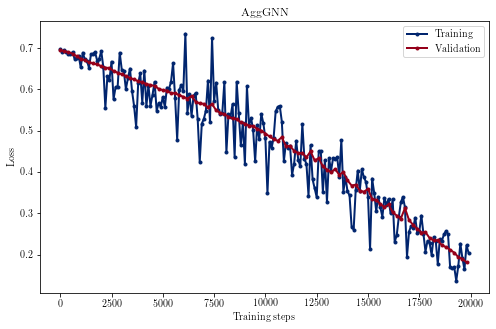

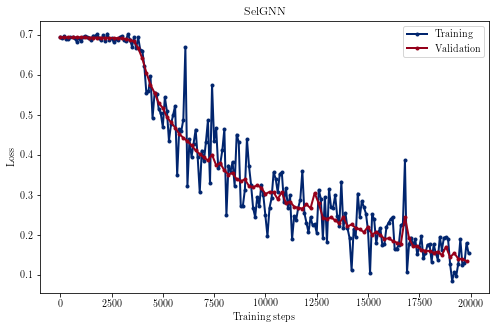

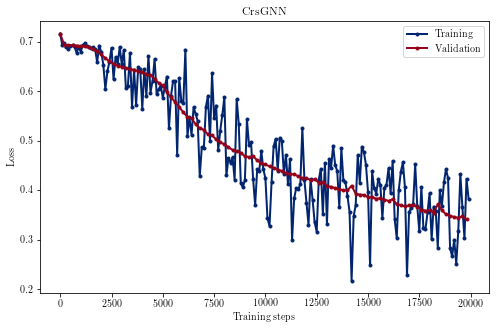

In [54]:
for key in lossTrain.keys():
    lossFig = plt.figure(figsize=(1.61*figSize, 1*figSize))
    plt.plot(xTrain, lossTrain[key],
             color = '#01256E', linewidth = lineWidth,
             marker = markerShape, markersize = markerSize)
    plt.plot(xValid, lossValid[key],
             color = '#95001A', linewidth = lineWidth,
             marker = markerShape, markersize = markerSize)
    plt.ylabel(r'Loss')
    plt.xlabel(r'Training steps')
    plt.legend([r'Training', r'Validation'])
    plt.title(r'%s' % key)
    lossFig.savefig(os.path.join(saveDirFigs,'loss%s.pdf' % key),
                    bbox_inches = 'tight')

Plot the evaluation measure (the classification accuracy) on both the training and validation set (one figure for each model)

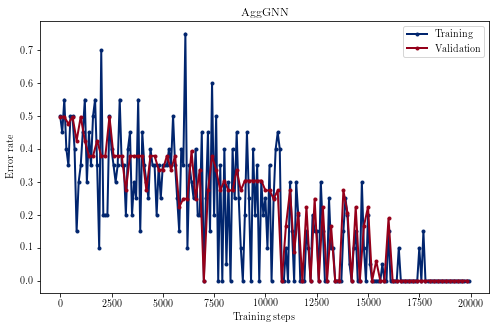

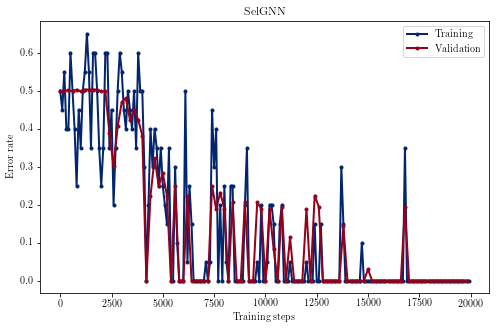

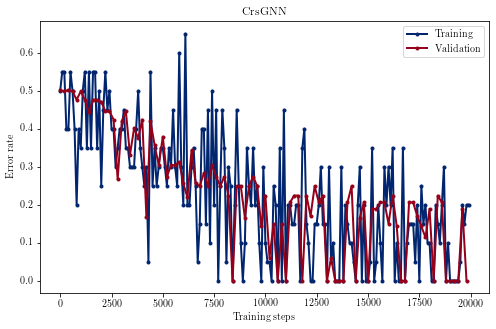

In [55]:
for key in evalTrain.keys():
    accFig = plt.figure(figsize=(1.61*figSize, 1*figSize))
    plt.plot(xTrain, evalTrain[key],
             color = '#01256E', linewidth = lineWidth,
             marker = markerShape, markersize = markerSize)
    plt.plot(xValid, evalValid[key],
             color = '#95001A', linewidth = lineWidth,
             marker = markerShape, markersize = markerSize)
    plt.ylabel(r'Error rate')
    plt.xlabel(r'Training steps')
    plt.legend([r'Training', r'Validation'])
    plt.title(r'%s' % key)
    accFig.savefig(os.path.join(saveDirFigs,'eval%s.pdf' % key),
                    bbox_inches = 'tight')

Plot the loss on the training set for all models (one figure, for comparison between models).

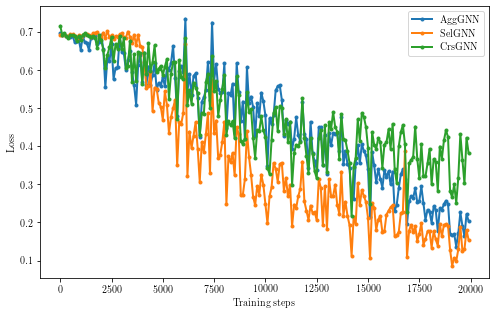

In [56]:
allLossTrain = plt.figure(figsize=(1.61*figSize, 1*figSize))
for key in lossTrain.keys():
    plt.plot(xTrain, lossTrain[key],
             linewidth = lineWidth,
             marker = markerShape, markersize = markerSize)
plt.ylabel(r'Loss')
plt.xlabel(r'Training steps')
plt.legend(list(lossTrain.keys()))
allLossTrain.savefig(os.path.join(saveDirFigs,'allLossTrain.pdf'),
                bbox_inches = 'tight')

Plot the evaluation measure (classification accuracy) on the validation set for all models (one figure).

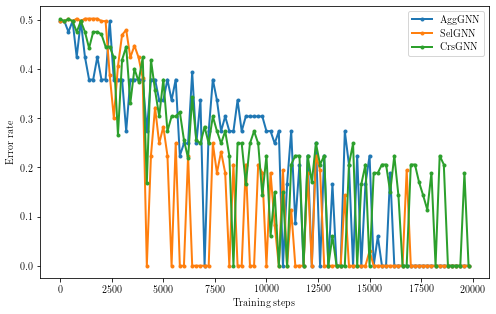

In [57]:
allEvalValid = plt.figure(figsize=(1.61*figSize, 1*figSize))
for key in evalValid.keys():
    plt.plot(xValid, evalValid[key],
             linewidth = lineWidth,
             marker = markerShape, markersize = markerSize)
plt.ylabel(r'Error rate')
plt.xlabel(r'Training steps')
plt.legend(list(evalValid.keys()))
allEvalValid.savefig(os.path.join(saveDirFigs,'allEvalValid.pdf'),
                bbox_inches = 'tight')

## Conclusion <a class="anchor" id="sec:conclusions"></a>
This concludes the tutorial. The main objective was to introduce the basic call to the architectures. Additionally, we reviewed the classes for graphs and datasets that could be useful. In particular, the data class has important attributes and methods that can work in tandem with training multiple models.

While only three architectures were overviewed in this tutorial, many more are available in <code>Modules.architectures</code>. Additionally, the <code>nn.Module</code>s defined in <code>Utils.graphML</code> can serve as basic layers for building other graph neural network architectures tailored to specific needs, hopefully in the same way as the layers in <code>torch.nn</code> are typically used.